# **Preprocessing**

In [787]:
# Set Working Directory 
import os 
os.chdir("/home/nico/BMIDS_FP")
os.getcwd()

'/home/nico/BMIDS_FP'

### Phecodes and ICD Diagnoses 
---

In [788]:
# Import relevant packages
import psycopg2
import pandas as pd
import numpy as np

In [789]:
# Load in Phecodes dataframes 
phecode_icd9 = pd.read_csv("phecode_icd9.csv")
phecode_icd10 = pd.read_csv("phecode_icd10.csv")

In [790]:
# View phecode_icd9
phecode_icd9.head(5) 

,row_ID,ICD9,ICD9 String,PheCode,Phenotype,Excl. Phecodes,Excl. Phenotypes,Rollup,Leaf,Ignore Bool
0,1,001,Cholera,8.0,Intestinal infection,001-009.99,Intestinal infection,1.0,0.0,0
1,2,001.0,Cholera due to Vibrio cholerae,8.0,Intestinal infection,001-009.99,Intestinal infection,1.0,0.0,0
2,3,001.1,Cholera due to Vibrio cholerae el tor,8.0,Intestinal infection,001-009.99,Intestinal infection,1.0,0.0,0
3,4,001.9,Cholera NOS,8.0,Intestinal infection,001-009.99,Intestinal infection,1.0,0.0,0
4,5,002,Typhoid and paratyphoid fevers,8.0,Intestinal infection,001-009.99,Intestinal infection,1.0,0.0,0


In [791]:
# View phecode_icd10
phecode_icd10.head(5) 

,row_ID,ICD10,ICD10 String,PheCode,Phenotype,Excl. Phecodes,Excl. Phenotypes
0,1,A00,Cholera,8.0,Intestinal infection,001-009.99,Intestinal infection
1,2,A00.0,"Cholera due to Vibrio cholerae 01, biovar chol...",8.0,Intestinal infection,001-009.99,Intestinal infection
2,3,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor",8.0,Intestinal infection,001-009.99,Intestinal infection
3,4,A00.9,"Cholera, unspecified",8.0,Intestinal infection,001-009.99,Intestinal infection
4,5,A01,Typhoid and paratyphoid fevers,8.0,Intestinal infection,001-009.99,Intestinal infection


In [792]:
# Make function to connect to specified schema and table in postgres
def postgres_connect(schema, table):
    connection={
    'host':'localhost',
    'dbname':'nico',
    'user':'nico',
    'password': '2484',
    'schema': schema,
    }

    conn_string = 'host={} dbname={} user={} password={}'.format(connection['host'],connection['dbname'],connection['user'],connection['password'])
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()

    query = "SELECT * FROM " + connection['schema'] + "." + table + ";"
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    table = pd.DataFrame(data, columns=columns)
    return table

In [793]:
# Get diagnoses_icd table
diagnoses_icd = postgres_connect("mimiciv_hosp", "diagnoses_icd")

In [794]:
# View 
diagnoses_icd

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9
...,...,...,...,...,...
19093459,19999987,23865745,7,41401,9
19093460,19999987,23865745,8,78039,9
19093461,19999987,23865745,9,0413,9
19093462,19999987,23865745,10,36846,9


In [795]:
# Merge phecode_icd9 to diagnoses_icd

# Remove leading/trailing whitespace and standardize formats
phecode_icd9['ICD9'] = phecode_icd9['ICD9'].astype(str).str.strip().str.replace('.', '', regex=False)
diagnoses_icd['icd_code'] = diagnoses_icd['icd_code'].astype(str).str.strip().str.replace('.', '', regex=False)

# Merge the tables
diagnoses_icd9 = (
    diagnoses_icd[diagnoses_icd['icd_version'] == 9]  # Filter for icd_version 9
    .merge(
        phecode_icd9, 
        left_on='icd_code', 
        right_on='ICD9', 
        how='left'
    )
    [['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version', 'ICD9 String', 'PheCode', 'Phenotype']]  # Select relevant columns
)

# Check the result
diagnoses_icd9

,subject_id,hadm_id,seq_num,icd_code,icd_version,ICD9 String,PheCode,Phenotype
0,10000032,22595853,1,5723,9,Portal hypertension,571.81,Portal hypertension
1,10000032,22595853,2,78959,9,Other ascites,572.00,Ascites (non malignant)
2,10000032,22595853,3,5715,9,Cirrhosis of liver without mention of alcohol,571.51,Cirrhosis of liver without mention of alcohol
3,10000032,22595853,4,07070,9,Unspecified viral hepatitis C without hepatic ...,70.30,Viral hepatitis C
4,10000032,22595853,5,496,9,"Chronic airway obstruction, not elsewhere clas...",496.00,Chronic airway obstruction
...,...,...,...,...,...,...,...,...
8911384,19999987,23865745,7,41401,9,Coronary atherosclerosis of native coronary ar...,411.40,Coronary atherosclerosis
8911385,19999987,23865745,8,78039,9,Other convulsions,345.30,Convulsions
8911386,19999987,23865745,9,0413,9,Friedlander's bacillus infection in conditions...,41.00,Bacterial infection NOS
8911387,19999987,23865745,10,36846,9,Homonymous bilateral field defects,368.40,Visual field defects


In [796]:
# Merge phecode_icd10 to diagnoses_icd

# Remove leading/trailing whitespace and standardize formats for ICD-10
phecode_icd10['ICD10'] = phecode_icd10['ICD10'].astype(str).str.strip().str.replace('.', '', regex=False)
diagnoses_icd['icd_code'] = diagnoses_icd['icd_code'].astype(str).str.strip().str.replace('.', '', regex=False)

# Merge the tables, focusing on ICD-10 codes
diagnoses_icd10 = (
    diagnoses_icd[diagnoses_icd['icd_version'] == 10]  # Filter for icd_version 10
    .merge(
        phecode_icd10, 
        left_on='icd_code', 
        right_on='ICD10', 
        how='left'
    )
    [['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version', 'ICD10 String', 'PheCode', 'Phenotype']]  # Select relevant columns
)

# Check the result
diagnoses_icd10

,subject_id,hadm_id,seq_num,icd_code,icd_version,ICD10 String,PheCode,Phenotype
0,10000084,23052089,1,G3183,10,NaN,NaN,NaN
1,10000084,23052089,2,F0280,10,NaN,NaN,NaN
2,10000084,23052089,3,R441,10,Visual hallucinations,368.9,Subjective visual disturbances
3,10000084,23052089,4,R296,10,NaN,NaN,NaN
4,10000084,23052089,5,E785,10,"Hyperlipidaemia, unspecified",272.1,Hyperlipidemia
...,...,...,...,...,...,...,...,...
10533463,19999828,29734428,18,Z9049,10,NaN,NaN,NaN
10533464,19999828,29734428,19,Z87891,10,NaN,NaN,NaN
10533465,19999828,29734428,20,B9620,10,NaN,NaN,NaN
10533466,19999828,29734428,21,Z1611,10,NaN,NaN,NaN


In [797]:
# Concatenate both tables
diagnoses_icd_phecodes = pd.concat([diagnoses_icd9, diagnoses_icd10], ignore_index=True)
diagnoses_icd_phecodes = diagnoses_icd_phecodes.drop(['ICD9 String', 'ICD10 String'], axis=1, errors='ignore')
diagnoses_icd_phecodes

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype
0,10000032,22595853,1,5723,9,571.81,Portal hypertension
1,10000032,22595853,2,78959,9,572.00,Ascites (non malignant)
2,10000032,22595853,3,5715,9,571.51,Cirrhosis of liver without mention of alcohol
3,10000032,22595853,4,07070,9,70.30,Viral hepatitis C
4,10000032,22595853,5,496,9,496.00,Chronic airway obstruction
...,...,...,...,...,...,...,...
19444852,19999828,29734428,18,Z9049,10,NaN,NaN
19444853,19999828,29734428,19,Z87891,10,NaN,NaN
19444854,19999828,29734428,20,B9620,10,NaN,NaN
19444855,19999828,29734428,21,Z1611,10,NaN,NaN


In [798]:
# Filter out hadm_ids that do not contain a cardiac arrest
diagnoses_icd_phecodes_CA_PC = diagnoses_icd_phecodes[diagnoses_icd_phecodes['PheCode'] == 427.42]
hadm_ids_diagnoses_icd_phecodes_CA = diagnoses_icd_phecodes_CA_PC['hadm_id'].unique()
diagnoses_icd_phecodes_CA = diagnoses_icd_phecodes[diagnoses_icd_phecodes['hadm_id'].isin(hadm_ids_diagnoses_icd_phecodes_CA)]

# View
diagnoses_icd_phecodes_CA

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype
1519,10004235,22187210,1,78062,9,783.10,Postprocedural fever
1520,10004235,22187210,2,V1253,9,427.42,Cardiac arrest
1521,10004235,22187210,3,29900,9,NaN,NaN
1522,10004235,22187210,4,4019,9,401.10,Essential hypertension
1523,10004235,22187210,5,V5861,9,286.20,Encounter for long-term (current) use of antic...
...,...,...,...,...,...,...,...
19441784,19990427,29695607,24,T24011A,10,NaN,NaN
19441785,19990427,29695607,25,Y658,10,NaN,NaN
19441786,19990427,29695607,26,Y92230,10,NaN,NaN
19441787,19990427,29695607,27,H168,10,370.00,Keratitis


### First ICU Admission
---

In [799]:
# Get icustays table
icustays = postgres_connect("mimiciv_icu", "icustays")

In [800]:
# View
icustays

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
...,...,...,...,...,...,...,...,...
94453,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
94454,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
94455,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
94456,19999840,21033226,38978960,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


In [801]:
# Merge icustays to diagnoses_icd_phecodes_CA
icustays_unique = icustays.drop_duplicates(subset=['hadm_id'], keep='first')
diagnoses_icd_phecodes_CA_ICU = pd.merge(diagnoses_icd_phecodes_CA, icustays_unique, on='hadm_id', how='left')

In [802]:
# View
diagnoses_icd_phecodes_CA_ICU

,subject_id_x,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,subject_id_y,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10004235,22187210,1,78062,9,783.10,Postprocedural fever,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,10004235,22187210,2,V1253,9,427.42,Cardiac arrest,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,10004235,22187210,3,29900,9,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,10004235,22187210,4,4019,9,401.10,Essential hypertension,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,10004235,22187210,5,V5861,9,286.20,Encounter for long-term (current) use of antic...,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171874,19990427,29695607,24,T24011A,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171875,19990427,29695607,25,Y658,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171876,19990427,29695607,26,Y92230,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171877,19990427,29695607,27,H168,10,370.00,Keratitis,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713


In [803]:
# Remove rows with no ICU stay id
diagnoses_icd_phecodes_CA_ICU = diagnoses_icd_phecodes_CA_ICU.dropna(subset=['stay_id'])
diagnoses_icd_phecodes_CA_ICU

,subject_id_x,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,subject_id_y,stay_id,first_careunit,last_careunit,intime,outtime,los
6,10004235,24181354,1,03842,9,38.1,Gram negative septicemia,10004235.0,34100191.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
7,10004235,24181354,2,78551,9,797.1,Cardiogenic shock,10004235.0,34100191.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
8,10004235,24181354,3,5845,9,585.1,Acute renal failure,10004235.0,34100191.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
9,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,10004235.0,34100191.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
10,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,10004235.0,34100191.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171874,19990427,29695607,24,T24011A,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171875,19990427,29695607,25,Y658,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171876,19990427,29695607,26,Y92230,10,NaN,NaN,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171877,19990427,29695607,27,H168,10,370.0,Keratitis,19990427.0,34058245.0,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713


In [804]:
# Drop unnecessary columns 
diagnoses_icd_phecodes_CA_ICU = diagnoses_icd_phecodes_CA_ICU.drop(columns=['subject_id_y', 'first_careunit', 'last_careunit'])
diagnoses_icd_phecodes_CA_ICU

,subject_id_x,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los
6,10004235,24181354,1,03842,9,38.1,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
7,10004235,24181354,2,78551,9,797.1,Cardiogenic shock,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
8,10004235,24181354,3,5845,9,585.1,Acute renal failure,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
9,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
10,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
...,...,...,...,...,...,...,...,...,...,...,...
171874,19990427,29695607,24,T24011A,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171875,19990427,29695607,25,Y658,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171876,19990427,29695607,26,Y92230,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
171877,19990427,29695607,27,H168,10,370.0,Keratitis,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713


In [805]:
# Only keep first unique value hadm_id for every subject_id
first_hadm_ids = diagnoses_icd_phecodes_CA_ICU.groupby('subject_id_x')['hadm_id'].first().reset_index()

diagnoses_icd_phecodes_CA_ICU_filtered = pd.merge(
    diagnoses_icd_phecodes_CA_ICU,
    first_hadm_ids,
    on=['subject_id_x', 'hadm_id'],
    how='inner'
    )

In [806]:
# Rename column and view
diagnoses_icd_phecodes_CA_ICU_filtered.rename(columns={'subject_id_x': 'subject_id'}, inplace=True)
diagnoses_icd_phecodes_CA_ICU_filtered

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los
0,10004235,24181354,1,03842,9,38.1,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
1,10004235,24181354,2,78551,9,797.1,Cardiogenic shock,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
2,10004235,24181354,3,5845,9,585.1,Acute renal failure,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
3,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
4,10004235,24181354,4,570,9,573.4,Acute and subacute necrosis of liver,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
...,...,...,...,...,...,...,...,...,...,...,...
132085,19990427,29695607,24,T24011A,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
132086,19990427,29695607,25,Y658,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
132087,19990427,29695607,26,Y92230,10,NaN,NaN,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713
132088,19990427,29695607,27,H168,10,370.0,Keratitis,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713


### Comorbidities
---

In [807]:
# Create a dataframe with only the first subject_id
diagnoses_icd_phecodes_CA_ICU_short = diagnoses_icd_phecodes_CA_ICU_filtered.drop_duplicates(subset='subject_id', keep='first')
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106
81,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741
147,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282
261,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255
324,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632
...,...,...,...,...,...,...,...,...,...,...,...
131730,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579
131808,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405
131886,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625
131931,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606


In [808]:
# Add the 'Hypertension' column for PheCode 401
diagnoses_icd_phecodes_CA_ICU_filtered['Hypertension'] = diagnoses_icd_phecodes_CA_ICU_filtered['PheCode'].astype(str).apply(lambda x: 1 if x.startswith('401.1') else 0)


In [809]:
hypertension_df = diagnoses_icd_phecodes_CA_ICU_filtered[diagnoses_icd_phecodes_CA_ICU_filtered['Hypertension'] == 1][['subject_id', 'Hypertension']]
hypertension_df = hypertension_df.drop_duplicates(subset=['subject_id'])
hypertension_df

,subject_id,Hypertension
339,10055361,1
486,10094679,1
710,10143305,1
1502,10213275,1
1599,10218368,1
...,...,...
130726,19743594,1
131087,19800412,1
131242,19871070,1
131640,19962250,1


In [810]:
# Add the 'Diabetes_Mellitus' column for PheCode 250.2
diagnoses_icd_phecodes_CA_ICU_filtered['Diabetes_Mellitus'] = diagnoses_icd_phecodes_CA_ICU_filtered['PheCode'].astype(str).apply(lambda x: 1 if x.startswith('250.2') else 0)

In [811]:
Diabetes_Mellitus_df = diagnoses_icd_phecodes_CA_ICU_filtered[diagnoses_icd_phecodes_CA_ICU_filtered['Diabetes_Mellitus'] == 1][['subject_id', 'Diabetes_Mellitus']]
Diabetes_Mellitus_df = Diabetes_Mellitus_df.drop_duplicates(subset=['subject_id'])
Diabetes_Mellitus_df

,subject_id,Diabetes_Mellitus
2305,10329745,1
3429,10496705,1
6765,10923152,1
7598,11062833,1
9112,11212873,1
...,...,...
130196,19609270,1
130500,19659865,1
131089,19800412,1
131243,19871070,1


In [812]:
# Add the 'COPD' column for PheCode 496
diagnoses_icd_phecodes_CA_ICU_filtered['COPD'] = diagnoses_icd_phecodes_CA_ICU_filtered['PheCode'].astype(str).apply(lambda x: 1 if x.startswith('496') else 0)

In [813]:
COPD_df = diagnoses_icd_phecodes_CA_ICU_filtered[diagnoses_icd_phecodes_CA_ICU_filtered['COPD'] == 1][['subject_id', 'COPD']]
COPD_df = COPD_df.drop_duplicates(subset=['subject_id'])
COPD_df

,subject_id,COPD
1486,10213275,1
1646,10231100,1
1874,10271174,1
3917,10584941,1
4743,10684803,1
...,...,...
129704,19514196,1
129895,19523963,1
130786,19757659,1
130887,19788246,1


In [814]:
# Merge the COPD data
diagnoses_icd_phecodes_CA_ICU_short = pd.merge(
    diagnoses_icd_phecodes_CA_ICU_short,
    COPD_df,
    on='subject_id',
    how='left'  
)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,NaN
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,NaN
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,NaN
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,NaN
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,NaN
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,NaN
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,NaN
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,NaN


In [815]:
# Replace NaN values in the 'COPD' column with 0
diagnoses_icd_phecodes_CA_ICU_short['COPD'] = diagnoses_icd_phecodes_CA_ICU_short['COPD'].fillna(0)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0


In [816]:
# Merge the Hypertension dataHypertension
diagnoses_icd_phecodes_CA_ICU_short = pd.merge(diagnoses_icd_phecodes_CA_ICU_short,
    hypertension_df,
    on='subject_id',
    how='left'  
)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD,Hypertension
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,NaN
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,NaN
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,NaN
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,NaN
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,NaN
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,NaN
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,NaN
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,NaN


In [817]:
# Replace NaN values in the 'Hypertension' column with 0
diagnoses_icd_phecodes_CA_ICU_short['Hypertension'] = diagnoses_icd_phecodes_CA_ICU_short['Hypertension'].fillna(0)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD,Hypertension
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0


In [818]:
# Merge the Diabetes_Mellitus data
diagnoses_icd_phecodes_CA_ICU_short = pd.merge(
    diagnoses_icd_phecodes_CA_ICU_short,
    Diabetes_Mellitus_df,
    on='subject_id',
    how='left'  
)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,NaN
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,NaN
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,NaN
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,NaN
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,NaN
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,NaN
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,NaN


In [819]:
# Replace NaN values in the 'Diabetes_Mellitus' column with 0
diagnoses_icd_phecodes_CA_ICU_short['Diabetes_Mellitus'] = diagnoses_icd_phecodes_CA_ICU_short['Diabetes_Mellitus'].fillna(0)
diagnoses_icd_phecodes_CA_ICU_short

,subject_id,hadm_id,seq_num,icd_code,icd_version,PheCode,Phenotype,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus
0,10004235,24181354,1,03842,9,38.10,Gram negative septicemia,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0
1,10004401,22869003,1,486,9,480.00,Pneumonia,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0
2,10013569,27993048,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0
3,10026161,24614671,1,1541,9,153.30,"Malignant neoplasm of rectum, rectosigmoid jun...",39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0
4,10055361,21240921,1,42823,9,428.30,Heart failure with reduced EF [Systolic or com...,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,1,I469,10,427.42,Cardiac arrest,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0
1913,19969137,20917922,1,A419,10,994.20,Sepsis,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0
1914,19970694,25071273,1,G253,10,333.20,Myoclonus,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0
1915,19971144,27369817,1,I469,10,427.42,Cardiac arrest,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0


In [820]:
# Drop unecessary columns 
diagnoses_icd_phecodes_CA_ICU_short = diagnoses_icd_phecodes_CA_ICU_short.drop(columns=['seq_num', 'icd_code', 'PheCode',"Phenotype", "icd_version"])

### Patients and Admissions
---

In [821]:
# Connect to mimiciv_hosp schema
connection={
    'host':'localhost',
    'dbname':'nico',
    'user':'nico',
    'password': '2484',
    'schema': 'mimiciv_hosp',
    }

conn_string = 'host={} dbname={} user={} password={}'.format(connection['host'],connection['dbname'],connection['user'],connection['password'])
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()

def query(querystring):
    conn.rollback()
    cursor.execute(querystring)
    records = cursor.fetchall()
    records=pd.DataFrame(records,columns=[i[0] for i in cursor.description])
    return records

In [822]:
# Run intermediate SQL query
querystring = """
    SELECT a.*, p.subject_id AS patient_subject_id, p.*
    FROM mimiciv_hosp.admissions AS a
    LEFT JOIN mimiciv_hosp.patients AS p
    ON a.subject_id = p.subject_id;
"""
merged_df = query(querystring)

In [823]:
# Drop duplicate columns
merged_df = merged_df.drop(columns=['subject_id'])
merged_df

,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,...,race,edregtime,edouttime,hospital_expire_flag,patient_subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,22148160,2163-08-20 01:42:00,2163-08-20 16:33:00,NaT,EU OBSERVATION,P73O7K,PHYSICIAN REFERRAL,None,Medicaid,English,...,WHITE,2163-08-19 22:35:00,2163-08-20 16:33:00,0,10000161,M,60,2163,2020 - 2022,None
1,27897940,2132-10-14 23:31:00,2132-10-19 16:30:00,NaT,URGENT,P38YR6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,English,...,WHITE,2132-10-14 19:31:00,2132-10-15 16:45:00,0,10000764,M,86,2132,2014 - 2016,None
2,21927847,2178-05-08 08:07:00,2178-05-08 11:46:00,NaT,EU OBSERVATION,P24H0T,EMERGENCY ROOM,None,None,English,...,UNABLE TO OBTAIN,2178-05-08 03:40:00,2178-05-08 11:46:00,0,10000886,M,18,2178,2008 - 2010,None
3,27880650,2121-05-09 10:02:00,2121-05-13 16:20:00,NaT,EW EMER.,P690UI,TRANSFER FROM HOSPITAL,HOME,Private,English,...,BLACK/AFRICAN AMERICAN,2121-05-09 07:25:00,2121-05-09 15:01:00,0,10000947,M,60,2121,2020 - 2022,2121-08-23
4,23005466,2135-07-20 03:45:00,2135-07-22 11:38:00,NaT,URGENT,P94QZF,PHYSICIAN REFERRAL,HOME,Private,English,...,WHITE,NaT,NaT,0,10001319,F,28,2133,2008 - 2010,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638079,27108332,2128-02-21 09:41:00,2128-02-22 17:04:00,NaT,EU OBSERVATION,P948LP,EMERGENCY ROOM,None,Medicare,English,...,BLACK/AFRICAN AMERICAN,2128-02-21 08:08:00,2128-02-21 11:54:00,0,19998350,M,52,2127,2011 - 2013,None
1638080,21606769,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,EW EMER.,P797L4,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,English,...,WHITE,2161-08-24 03:14:00,2161-08-24 05:26:00,0,19999068,M,63,2161,2011 - 2013,None
1638081,22917423,2123-01-27 15:47:00,2123-01-27 21:39:00,NaT,EU OBSERVATION,P47DQU,EMERGENCY ROOM,None,Private,English,...,WHITE,2123-01-27 13:13:00,2123-01-27 21:39:00,0,19999156,F,62,2123,2011 - 2013,None
1638082,29046609,2146-05-30 16:43:00,2146-06-08 20:20:00,NaT,OBSERVATION ADMIT,P23ZZK,TRANSFER FROM HOSPITAL,HOME,Medicare,English,...,WHITE,2146-05-30 14:10:00,2146-05-30 20:09:00,0,19999204,M,61,2146,2017 - 2019,2146-08-29


In [824]:
# Remove duplicates based on `hadm_id`
merged_df = merged_df.drop_duplicates(subset='hadm_id', keep='first')

In [825]:
# Merge to diagnoses_icd_phecodes_CA_ICU_short table
merged_df_main = diagnoses_icd_phecodes_CA_ICU_short.merge(merged_df, on='hadm_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,admittime,...,race,edregtime,edouttime,hospital_expire_flag,patient_subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,2196-02-24 14:38:00,...,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,10004235,M,47,2196,2014 - 2016,None
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,2144-04-05 09:31:00,...,WHITE,2144-04-05 08:17:00,2144-04-05 10:57:00,0,10004401,M,82,2141,2008 - 2010,2144-06-18
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,2167-11-19 08:23:00,...,WHITE,2167-11-19 00:01:00,2167-11-19 09:52:00,0,10013569,F,54,2165,2008 - 2010,None
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,2133-11-11 07:15:00,...,WHITE,NaT,NaT,1,10026161,M,78,2133,2008 - 2010,2133-11-15
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,2166-09-17 04:22:00,...,WHITE,2166-09-17 02:15:00,2166-09-17 05:23:00,0,10055361,M,62,2166,2014 - 2016,2166-10-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,2158-09-27 22:06:00,...,BLACK/CARIBBEAN ISLAND,2158-09-27 18:03:00,2158-09-27 22:51:00,1,19966756,M,72,2145,2008 - 2010,2158-09-29
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,2143-03-20 02:28:00,...,WHITE,2143-03-19 20:43:00,2143-03-20 03:52:00,0,19969137,F,46,2143,2017 - 2019,None
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,2166-09-16 18:27:00,...,UNKNOWN,NaT,NaT,0,19970694,F,69,2166,2020 - 2022,2166-09-23
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,2146-11-10 17:34:00,...,UNKNOWN,2146-11-10 16:01:00,2146-11-10 19:29:00,1,19971144,F,79,2146,2020 - 2022,2146-11-11


In [826]:
# Get Ages
Age = postgres_connect("mimiciv_derived", "age")

In [827]:
# View Age 
Age

,subject_id,hadm_id,admittime,anchor_age,anchor_year,age
0,10000084,23052089,2160-11-21 01:56:00,72,2160,72.89004154931676958169
1,10000084,29888819,2160-12-28 05:11:00,72,2160,72.99171500600210879971
2,10000764,27897940,2132-10-14 23:31:00,86,2132,86.78846315897709220492
3,10001186,21334040,2190-07-19 07:15:00,46,2188,48.5470840794140141
4,10001186,24016413,2188-10-20 07:15:00,46,2188,46.80303492844013923189
...,...,...,...,...,...,...
1638079,19998878,27930413,2132-05-23 16:10:00,56,2132,56.39336552507956672867
1638080,19998878,29356037,2132-08-17 20:59:00,56,2132,56.62937533349274058174
1638081,19999068,21606769,2161-08-24 04:10:00,63,2161,63.64388435916765079348
1638082,19999298,27518724,2177-02-10 06:41:00,20,2177,20.11027886229464908806


In [828]:
# Merge to Age to main dataframe table
merged_df_main = merged_df_main.merge(Age[['hadm_id','age']], on='hadm_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,admittime,...,edregtime,edouttime,hospital_expire_flag,patient_subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,age
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,2196-02-24 14:38:00,...,2196-02-24 12:15:00,2196-02-24 17:07:00,0,10004235,M,47,2196,2014 - 2016,None,47.14951654580311744603
1,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,2196-02-24 14:38:00,...,2196-02-24 12:15:00,2196-02-24 17:07:00,0,10004235,M,47,2196,2014 - 2016,None,47.14951654580311744603
2,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,2196-02-24 14:38:00,...,2196-02-24 12:15:00,2196-02-24 17:07:00,0,10004235,M,47,2196,2014 - 2016,None,47.14951654580311744603
3,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,2144-04-05 09:31:00,...,2144-04-05 08:17:00,2144-04-05 10:57:00,0,10004401,M,82,2141,2008 - 2010,2144-06-18,85.2591994561900816
4,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,2144-04-05 09:31:00,...,2144-04-05 08:17:00,2144-04-05 10:57:00,0,10004401,M,82,2141,2008 - 2010,2144-06-18,85.2591994561900816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5746,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,2146-11-10 17:34:00,...,2146-11-10 16:01:00,2146-11-10 19:29:00,1,19971144,F,79,2146,2020 - 2022,2146-11-11,79.85897006490065338719
5747,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,2146-11-10 17:34:00,...,2146-11-10 16:01:00,2146-11-10 19:29:00,1,19971144,F,79,2146,2020 - 2022,2146-11-11,79.85897006490065338719
5748,19990427,29695607,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713,0.0,1.0,0.0,2182-01-04 00:00:00,...,NaT,NaT,1,19990427,F,67,2182,2017 - 2019,2182-01-24,67.00821373226518308409
5749,19990427,29695607,34058245.0,2182-01-14 04:16:54,2182-01-23 21:50:34,9.731713,0.0,1.0,0.0,2182-01-04 00:00:00,...,NaT,NaT,1,19990427,F,67,2182,2017 - 2019,2182-01-24,67.00821373226518308409


In [829]:
# Drop duplicates
merged_df_main = merged_df_main.drop_duplicates(subset='subject_id', keep='first')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,admittime,...,edregtime,edouttime,hospital_expire_flag,patient_subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,age
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,2196-02-24 14:38:00,...,2196-02-24 12:15:00,2196-02-24 17:07:00,0,10004235,M,47,2196,2014 - 2016,None,47.14951654580311744603
3,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,2144-04-05 09:31:00,...,2144-04-05 08:17:00,2144-04-05 10:57:00,0,10004401,M,82,2141,2008 - 2010,2144-06-18,85.2591994561900816
6,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,2167-11-19 08:23:00,...,2167-11-19 00:01:00,2167-11-19 09:52:00,0,10013569,F,54,2165,2008 - 2010,None,56.8812384817615596
9,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,2133-11-11 07:15:00,...,NaT,NaT,1,10026161,M,78,2133,2008 - 2010,2133-11-15,78.86053105429642082053
12,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,2166-09-17 04:22:00,...,2166-09-17 02:15:00,2166-09-17 05:23:00,0,10055361,M,62,2166,2014 - 2016,2166-10-03,62.70961703321207430811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5736,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,2158-09-27 22:06:00,...,2158-09-27 18:03:00,2158-09-27 22:51:00,1,19966756,M,72,2145,2008 - 2010,2158-09-29,85.7386194176281297
5739,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,2143-03-20 02:28:00,...,2143-03-19 20:43:00,2143-03-20 03:52:00,0,19969137,F,46,2143,2017 - 2019,None,46.21383843527791923650
5742,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,2166-09-16 18:27:00,...,NaT,NaT,0,19970694,F,69,2166,2020 - 2022,2166-09-23,69.70848574369869839723
5745,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,2146-11-10 17:34:00,...,2146-11-10 16:01:00,2146-11-10 19:29:00,1,19971144,F,79,2146,2020 - 2022,2146-11-11,79.85897006490065338719


In [830]:
# Drop unecessary columns
merged_df_main = merged_df_main.drop(columns=['admittime', 'dischtime','deathtime', 'admission_type', 'admit_provider_id','admission_location', 'discharge_location', 
                                         'insurance', 'language','marital_status', 'race', 'edregtime', 'edouttime','patient_subject_id','anchor_year', 'anchor_year_group','dod',"anchor_age"])
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603
3,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816
6,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596
9,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053
12,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811
...,...,...,...,...,...,...,...,...,...,...,...,...
5736,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297
5739,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650
5742,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723
5745,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719


In [831]:
# filter for age greater than or equal to 18
merged_df_main = merged_df_main[merged_df_main['age'] > 17]
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603
3,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816
6,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596
9,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053
12,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811
...,...,...,...,...,...,...,...,...,...,...,...,...
5736,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297
5739,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650
5742,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723
5745,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719


### Add Medical Scores
---

In [832]:
# Get SAPS II Score
sapsii = postgres_connect("mimiciv_derived", "sapsii")

In [833]:
# View
sapsii

,subject_id,hadm_id,stay_id,starttime,endtime,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,...,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score
0,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
1,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
2,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
3,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
4,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850117,10053207,29999444,31112026,2199-12-14 19:52:26,2199-12-15 19:52:26,26,0.071716,7,4.0,0.0,...,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0,6
850118,10053207,29999444,31112026,2199-12-14 19:52:26,2199-12-15 19:52:26,26,0.071716,7,4.0,0.0,...,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0,6
850119,10053207,29999444,31112026,2199-12-14 19:52:26,2199-12-15 19:52:26,26,0.071716,7,4.0,0.0,...,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0,6
850120,10053207,29999444,31112026,2199-12-14 19:52:26,2199-12-15 19:52:26,26,0.071716,7,4.0,0.0,...,0.0,6.0,0.0,0.0,0.0,3.0,0.0,0.0,0,6


In [834]:
# Keep only first sapsii score
sapsii = sapsii.drop_duplicates(subset='subject_id', keep='first')
sapsii

,subject_id,hadm_id,stay_id,starttime,endtime,sapsii,sapsii_prob,age_score,hr_score,sysbp_score,...,uo_score,bun_score,wbc_score,potassium_score,sodium_score,bicarbonate_score,bilirubin_score,gcs_score,comorbidity_score,admissiontype_score
0,10547209,20002833,35187049,2124-11-18 22:26:04,2124-11-19 22:26:04,20,0.037205,7,2.0,5.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6
9,18596567,20002950,32853022,2134-06-21 21:52:00,2134-06-22 21:52:00,12,0.013110,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6
18,16042415,20003019,30683386,2155-08-10 21:25:00,2155-08-11 21:25:00,22,0.046739,0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,0,6
27,16110697,20013602,38279102,2114-11-21 06:57:00,2114-11-22 06:57:00,37,0.196366,18,2.0,5.0,...,0.0,6.0,0.0,0.0,0.0,0.0,NaN,0.0,0,6
36,19650702,20013839,38119074,2118-07-07 07:30:00,2118-07-08 07:30:00,28,0.087706,12,0.0,5.0,...,0.0,0.0,3.0,0.0,0.0,0.0,NaN,0.0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850041,16172736,29972486,32078161,2157-11-13 04:31:51,2157-11-14 04:31:51,41,0.266087,15,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0,8
850050,11087224,29975017,34836186,2127-12-31 01:05:54,2128-01-01 01:05:54,36,0.181020,16,0.0,5.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,6
850059,15527910,29984348,37285354,2187-05-28 17:38:28,2187-05-29 17:38:28,34,0.152870,12,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9,8
850068,19226640,29986237,37139464,2165-08-26 23:38:50,2165-08-27 23:38:50,33,0.140051,7,0.0,0.0,...,0.0,6.0,0.0,0.0,5.0,0.0,9.0,0.0,0,6


In [835]:
# Get GCS Score
gcs = postgres_connect("mimiciv_derived", "gcs")

In [836]:
# View 
gcs

,subject_id,stay_id,charttime,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable
0,12466550,30000153,2174-09-29 12:45:00,15.0,5.0,0.0,3.0,1
1,12466550,30000153,2174-09-29 16:26:00,15.0,6.0,0.0,4.0,1
2,12466550,30000153,2174-09-29 17:37:00,15.0,6.0,0.0,4.0,1
3,12466550,30000153,2174-09-29 18:00:00,9.0,5.0,1.0,3.0,0
4,12466550,30000153,2174-09-29 19:00:00,9.0,5.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...
2217782,10826461,39999858,2167-04-29 20:00:00,15.0,6.0,5.0,4.0,0
2217783,10826461,39999858,2167-04-30 00:00:00,15.0,6.0,5.0,4.0,0
2217784,10826461,39999858,2167-04-30 04:00:00,15.0,6.0,5.0,4.0,0
2217785,10826461,39999858,2167-04-30 07:00:00,15.0,6.0,5.0,4.0,0


In [837]:
# Keep only first gcs score
gcs = gcs.drop_duplicates(subset='subject_id', keep='first')
gcs

,subject_id,stay_id,charttime,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable
0,12466550,30000153,2174-09-29 12:45:00,15.0,5.0,0.0,3.0,1
24,13180007,30000213,2162-06-21 06:00:00,15.0,4.0,0.0,2.0,1
35,18421337,30000484,2136-01-14 18:56:00,6.0,1.0,1.0,4.0,0
50,12207593,30000646,2194-04-29 01:54:00,15.0,6.0,5.0,4.0,0
67,15726459,30000831,2140-04-17 21:54:00,8.0,4.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...
2217681,15498623,39999384,2158-05-24 22:00:00,15.0,6.0,5.0,4.0,0
2217689,11256534,39999552,2186-07-17 17:12:00,3.0,1.0,1.0,1.0,0
2217694,15403458,39999562,2129-01-24 17:43:00,15.0,6.0,5.0,4.0,0
2217723,17840864,39999810,2115-12-01 00:55:00,14.0,6.0,5.0,3.0,0


In [838]:
# Get sofa Score
sofa = postgres_connect("mimiciv_derived", "sofa")

In [839]:
# View
sofa

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
0,30000153,0,2174-09-29 12:00:00,2174-09-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
1,30000153,1,2174-09-29 13:00:00,2174-09-29 14:00:00,NaN,442.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,0,0,0
2,30000153,2,2174-09-29 14:00:00,2174-09-29 15:00:00,NaN,526.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,30000153,3,2174-09-29 15:00:00,2174-09-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0,0,0,0,0,0,0
4,30000153,4,2174-09-29 16:00:00,2174-09-29 17:00:00,NaN,430.0,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8219116,39999858,87,2167-04-30 04:00:00,2167-04-30 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,0,1,0,0,1
8219117,39999858,88,2167-04-30 05:00:00,2167-04-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,0,0,0,1,0,0,1
8219118,39999858,89,2167-04-30 06:00:00,2167-04-30 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0,0,0,1,0,0,1
8219119,39999858,90,2167-04-30 07:00:00,2167-04-30 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0,0,0,1,0,0,1


In [840]:
# Keep only first sofa score
sofa = sofa.drop_duplicates(subset='stay_id', keep='first')
sofa

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,...,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
0,30000153,0,2174-09-29 12:00:00,2174-09-29 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
40,30000213,0,2162-06-21 05:00:00,2162-06-21 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
78,30000484,0,2136-01-14 18:00:00,2136-01-14 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,NaN,0,0,0,0,3,0,3
137,30000646,0,2194-04-29 01:00:00,2194-04-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,0,0,0,0,0,0
251,30000831,0,2140-04-17 21:00:00,2140-04-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,2.0,0,0,0,0,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8218747,39999384,0,2158-05-24 20:00:00,2158-05-24 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0,0,0,0,0,0,0
8218777,39999552,0,2186-07-17 16:00:00,2186-07-17 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,0,0,0,0,0,0,0
8218803,39999562,0,2129-01-24 17:00:00,2129-01-24 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0,1,0,0,0,0,1
8218917,39999810,0,2115-12-01 01:00:00,2115-12-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,0,0,0,0,1,0,1


In [841]:
# Add sapsii score
merged_df_main = merged_df_main.merge(sapsii[['subject_id','sapsii']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58


In [842]:
# Add gcs score
merged_df_main = merged_df_main.merge(gcs[['subject_id','gcs']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0


In [843]:
# Add sofa score
merged_df_main = merged_df_main.merge(sofa[['stay_id','sofa_24hours']], on='stay_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0


### Add Lab Paramaters and Tests
---

### BMI

In [844]:
# Create list of subject_ids 
subject_id_list = merged_df_main['subject_id'].tolist()

In [845]:
# Get chartevents table, too computationally intensive to access from postgres 
#chartevents = pd.read_csv("chartevents.csv")

In [846]:
# Filter out irrelevant subject_ids
chartevents = chartevents[chartevents['subject_id'].isin(subject_id_list)]

In [847]:
# Get item_id table
d_items = postgres_connect("mimiciv_icu", "d_items")

In [848]:
# Merge d_items to chartevents
items_bmi=chartevents.merge(d_items.loc[:,['itemid','label']],how='left',left_on='itemid',right_on='itemid')

In [849]:
# Find 'height' items
unqlabels=pd.Series(items_bmi.label.unique())
unqlabels[unqlabels.str.contains('height',case=False,na=False)]

364         Height
365    Height (cm)
dtype: object

In [850]:
# Find the item corresponding to 'Height (cm)'
d_items[d_items['label']=='Height (cm)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1945,226730,Height (cm),Height (cm),chartevents,General,cm,Numeric,NaN,NaN


In [851]:
# Find the itemid corresponding to 'Height (cm)'
d_items[d_items['label']=='Height']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
1941,226707,Height,Height,chartevents,General,Inch,Numeric,NaN,NaN


In [852]:
# Find 'Weight' items
unqlabels[unqlabels.str.contains('weight',case=False,na=False)]

326    Unintentional weight loss >10 lbs.
358                 Admission Weight (Kg)
366               Admission Weight (lbs.)
431                          Daily Weight
733                        Feeding Weight
dtype: object

In [853]:
# Find the itemid corresponding to 'Admission Weight (Kg)'
d_items[d_items['label']=='Daily Weight']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
766,224639,Daily Weight,Daily Weight,chartevents,General,kg,Numeric,NaN,NaN


In [854]:
# Weight and Height Itemids
w_itemids=[226512, 224639]
h_itemids=[226730,226707]

In [855]:
# Create column for this item
items_bmi['ITEM']=None
items_bmi.loc[items_bmi.itemid.isin(w_itemids) & items_bmi.valuenum.notnull(),'ITEM']='Weight'
items_bmi.loc[items_bmi.itemid.isin(h_itemids) & items_bmi.valuenum.notnull(),'ITEM']='Height'

In [856]:
# View Height 
items_bmi.loc[items_bmi['ITEM'] == 'Height']

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
13850,23087,10001884,26184834,37510196,91398.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226707,62,62.0,Inch,0.0,Height,Height
13851,23088,10001884,26184834,37510196,91398.0,2131-01-11 04:20:00,2131-01-13 14:43:00,226730,157,157.0,cm,0.0,Height (cm),Height
20530,160991,10004235,24181354,34100191,82715.0,2196-02-24 14:39:00,2196-02-28 18:02:00,226707,72,72.0,Inch,0.0,Height,Height
20531,160992,10004235,24181354,34100191,82715.0,2196-02-24 14:39:00,2196-02-28 18:02:00,226730,183,183.0,cm,0.0,Height (cm),Height
26316,166779,10004401,22869003,38292466,55368.0,2144-04-05 09:32:00,2144-04-06 16:13:00,226707,67,67.0,Inch,0.0,Height,Height
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25556300,432145304,19983257,21588174,30916791,22746.0,2166-06-13 14:22:00,2166-06-15 12:17:00,226730,165,165.0,cm,0.0,Height (cm),Height
25569984,432507830,19990427,29695607,34058245,87786.0,2182-01-14 04:16:00,2182-01-14 10:37:00,226707,65,65.0,Inch,0.0,Height,Height
25569985,432507831,19990427,29695607,34058245,87786.0,2182-01-14 04:16:00,2182-01-14 10:37:00,226730,165,165.0,cm,0.0,Height (cm),Height
25588211,432818739,19997367,20617667,35616526,28759.0,2126-04-21 10:08:00,2126-04-21 11:47:00,226707,58,58.0,Inch,0.0,Height,Height


In [857]:
# View Weight 
items_bmi.loc[items_bmi['ITEM'] == 'Weight']

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
12239,21476,10001884,26184834,37510196,80463.0,2131-01-11 04:20:00,2131-01-11 04:30:00,226512,65,65.0,kg,0.0,Admission Weight (Kg),Weight
14510,155880,10004235,24181354,34100191,3178.0,2196-02-27 07:04:00,2196-02-27 07:05:00,224639,130,130.0,kg,0.0,Daily Weight,Weight
14684,155142,10004235,24181354,34100191,3178.0,2196-02-26 01:00:00,2196-02-26 01:28:00,224639,130,130.0,kg,0.0,Daily Weight,Weight
14717,155175,10004235,24181354,34100191,3178.0,2196-02-26 02:00:00,2196-02-26 02:01:00,224639,130,130.0,kg,0.0,Daily Weight,Weight
14786,155244,10004235,24181354,34100191,3178.0,2196-02-26 02:03:00,2196-02-26 02:03:00,224639,130,130.0,kg,0.0,Daily Weight,Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25598884,432829412,19997367,20617667,35616526,82589.0,2126-05-03 04:00:00,2126-05-03 04:34:00,224639,72.8,72.8,kg,0.0,Daily Weight,Weight
25599221,432829750,19997367,20617667,35616526,82589.0,2126-05-05 05:00:00,2126-05-05 05:53:00,224639,70.2,70.2,kg,0.0,Daily Weight,Weight
25599478,432830007,19997367,20617667,35616526,82589.0,2126-05-09 03:00:00,2126-05-09 03:18:00,224639,65.4,65.4,kg,0.0,Daily Weight,Weight
25605533,432836062,19997367,21508795,36980198,12314.0,2127-04-06 04:00:00,2127-04-06 04:13:00,224639,58.3,58.3,kg,0.0,Daily Weight,Weight


In [858]:
# Check weight units
items_bmi.loc[items_bmi.ITEM=='Weight','valueuom'].unique()

array(['kg'], dtype=object)

In [859]:
# Check Height units
items_bmi.loc[items_bmi.ITEM=='Height','valueuom'].unique()

array(['Inch', 'cm'], dtype=object)

In [860]:
# Convert Height to cm
inchidx=(items_bmi.ITEM=='Height') & (items_bmi.valueuom!='cm')
items_bmi.loc[inchidx,'valuenum']=items_bmi.loc[inchidx,'valuenum']*2.54
items_bmi.loc[inchidx,'valueuom']='cm'

In [861]:
# Visualize data in a pivot table
pivotdf=items_bmi.pivot_table(values='valuenum',index=['subject_id','charttime'],columns='ITEM')
pivotdf

ITEM                            Height  Weight
subject_id charttime                          
10001884   2131-01-11 04:20:00  157.24    65.0
10004235   2196-02-24 14:39:00  182.94   127.0
           2196-02-25 03:00:00     NaN   130.0
           2196-02-26 01:00:00     NaN   130.0
           2196-02-26 02:00:00     NaN   130.0
...                                ...     ...
19997367   2126-05-13 05:00:00     NaN    63.0
           2126-05-14 05:00:00     NaN    65.1
           2126-05-16 05:00:00     NaN    61.0
           2127-04-02 12:46:00     NaN    50.0
           2127-04-06 04:00:00     NaN    58.3

[25637 rows x 2 columns]

In [862]:
# Get mean Heigth and Weight
meandf=pivotdf.groupby('subject_id').mean()
meandf

ITEM,Height,Weight
subject_id,,
10001884,157.2400,65.000000
10004235,182.9400,129.930233
10004401,169.6360,80.664286
10009823,167.8200,91.300000
10013569,116.9200,86.993333
...,...,...
19975796,164.0674,55.880000
19975898,170.0900,90.450000
19983257,165.0500,129.425000


In [863]:
# Impute the mean
meandf.loc[meandf.Height.isnull(),'Height']=meandf.Height.mean()
meandf.loc[meandf.Weight.isnull(),'Weight']=meandf.Weight.mean()

In [864]:
#Calculate BMI
meandf['BMI']=meandf['Weight']/(meandf['Height']/100)**2
meandf

ITEM,Height,Weight,BMI
subject_id,,,
10001884,157.2400,65.000000,26.289800
10004235,182.9400,129.930233,38.823337
10004401,169.6360,80.664286,28.031430
10009823,167.8200,91.300000,32.417785
10013569,116.9200,86.993333,63.636804
...,...,...,...
19975796,164.0674,55.880000,20.759257
19975898,170.0900,90.450000,31.264466
19983257,165.0500,129.425000,47.510228


In [865]:
# Reset Index
meandf = meandf.reset_index()
meandf

ITEM,subject_id,Height,Weight,BMI
0,10001884,157.2400,65.000000,26.289800
1,10004235,182.9400,129.930233,38.823337
2,10004401,169.6360,80.664286,28.031430
3,10009823,167.8200,91.300000,32.417785
4,10013569,116.9200,86.993333,63.636804
...,...,...,...,...
1904,19975796,164.0674,55.880000,20.759257
1905,19975898,170.0900,90.450000,31.264466
1906,19983257,165.0500,129.425000,47.510228
1907,19990427,165.0500,97.540000,35.805661


In [866]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','BMI']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0,37.821338


In [867]:
# Check for any Null values
merged_df_main['BMI'].isnull().sum()

8

### Heartrate

In [868]:
# Get merged chartevents and d_items df
items_hr = items_bmi
items_hr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [869]:
# Find the itemid corresponding to Heart Rate
d_items[d_items['label']=='Heart Rate']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN


In [870]:
# Inspect Heart Rate Data
items_hr = items_hr[items_hr['itemid'] == 220045]

In [871]:
# Ensure charttime is in datetime format
items_hr['charttime'] = pd.to_datetime(items_hr['charttime'])

/tmp/ipykernel_5563/832033902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_hr['charttime'] = pd.to_datetime(items_hr['charttime'])


In [872]:
# Create Function to get only 12 hours of Heart Rate Data for each Subject
def filter_first_12hrs(group):
    # Get the first charttime for the subject
    first_charttime = group['charttime'].min()
    # Filter rows within the first 12 hours
    return group[group['charttime'] <= (first_charttime + pd.Timedelta(hours=12))]

In [873]:
# Group by subject_id and apply the filter function
items_hr = items_hr.groupby('subject_id').apply(filter_first_12hrs)

In [874]:
# View
items_hr = items_hr.reset_index(drop=True)
items_hr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9271,10001884,26184834,37510196,3178.0,2131-01-11 06:00:00,2131-01-11 06:47:00,220045,72,72.0,bpm,0.0,Heart Rate,None
1,9278,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220045,71,71.0,bpm,0.0,Heart Rate,None
2,9327,10001884,26184834,37510196,3178.0,2131-01-11 07:00:00,2131-01-11 07:03:00,220045,70,70.0,bpm,0.0,Heart Rate,None
3,13602,10001884,26184834,37510196,30614.0,2131-01-11 06:44:00,2131-01-11 06:44:00,220045,71,71.0,bpm,0.0,Heart Rate,None
4,15747,10001884,26184834,37510196,40490.0,2131-01-11 08:00:00,2131-01-11 08:27:00,220045,71,71.0,bpm,0.0,Heart Rate,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33289,432831555,19997367,20617667,35616526,92357.0,2126-04-21 16:00:00,2126-04-21 16:18:00,220045,87,87.0,bpm,0.0,Heart Rate,None
33290,432831605,19997367,20617667,35616526,92357.0,2126-04-21 16:30:00,2126-04-21 16:32:00,220045,86,86.0,bpm,0.0,Heart Rate,None
33291,432831648,19997367,20617667,35616526,92357.0,2126-04-21 17:00:00,2126-04-21 17:09:00,220045,82,82.0,bpm,0.0,Heart Rate,None
33292,432831712,19997367,20617667,35616526,92357.0,2126-04-21 18:00:00,2126-04-21 18:11:00,220045,80,80.0,bpm,0.0,Heart Rate,None


In [875]:
# Check Units
items_hr['valueuom'].unique()

array(['bpm'], dtype=object)

In [876]:
# Create a pivot table
pivotdf=items_hr.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 04:22:00      38.0
           2131-01-11 05:00:00      60.0
           2131-01-11 06:00:00      72.0
           2131-01-11 06:44:00      71.0
           2131-01-11 06:47:00      71.0
...                                  ...
19997367   2126-04-21 19:00:00      76.0
           2126-04-21 20:00:00      83.0
           2126-04-21 21:00:00      90.0
           2126-04-21 22:00:00      91.0
           2126-04-21 23:00:00      85.0

[33294 rows x 1 columns]

In [877]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Heart_Rate'})
meandf

,subject_id,Heart_Rate
0,10001884,67.666667
1,10004235,116.600000
2,10004401,70.375000
3,10009823,106.461538
4,10013569,75.187500
...,...,...
1912,19975796,82.461538
1913,19975898,71.192308
1914,19983257,80.285714
1915,19990427,126.270270


In [878]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Heart_Rate']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,Heart_Rate
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,116.600000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,70.375000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,75.187500
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,79.450000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,97.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,85.470588
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,89.384615
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,58.230769
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0,37.821338,123.625000


In [879]:
# Check for any Null values
merged_df_main['Heart_Rate'].isnull().sum()

0

### Respiratory Rate

In [880]:
# Get merged chartevents and d_items df
items_rr = items_bmi
items_rr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [881]:
# Find the itemid corresponding to Respiratory Rate	
d_items[d_items['label']=='Respiratory Rate']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
28,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN


In [882]:
# Inspect Respiratory Rate Data
items_rr = items_rr[items_rr['itemid'] == 220210]
items_rr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
36,9273,10001884,26184834,37510196,3178.0,2131-01-11 06:00:00,2131-01-11 06:47:00,220210,20,20.0,insp/min,0.0,Respiratory Rate,None
45,9282,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220210,15,15.0,insp/min,0.0,Respiratory Rate,None
92,9329,10001884,26184834,37510196,3178.0,2131-01-11 07:00:00,2131-01-11 07:03:00,220210,18,18.0,insp/min,0.0,Respiratory Rate,None
227,9464,10001884,26184834,37510196,6823.0,2131-01-15 20:00:00,2131-01-15 21:47:00,220210,15,15.0,insp/min,0.0,Respiratory Rate,None
301,9538,10001884,26184834,37510196,6823.0,2131-01-15 21:00:00,2131-01-15 21:47:00,220210,19,19.0,insp/min,0.0,Respiratory Rate,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608457,432838986,19997367,21508795,36980198,75129.0,2127-04-03 03:00:00,2127-04-03 03:20:00,220210,17,17.0,insp/min,0.0,Respiratory Rate,None
25608566,432839095,19997367,21508795,36980198,75129.0,2127-04-03 04:01:00,2127-04-03 04:24:00,220210,12,12.0,insp/min,0.0,Respiratory Rate,None
25608589,432839118,19997367,21508795,36980198,75129.0,2127-04-03 05:00:00,2127-04-03 05:08:00,220210,23,23.0,insp/min,0.0,Respiratory Rate,None
25608600,432839129,19997367,21508795,36980198,75129.0,2127-04-03 06:00:00,2127-04-03 06:03:00,220210,19,19.0,insp/min,0.0,Respiratory Rate,None


In [883]:
# Ensure charttime is in datetime format
items_rr['charttime'] = pd.to_datetime(items_rr['charttime'])

/tmp/ipykernel_5563/3340415546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_rr['charttime'] = pd.to_datetime(items_rr['charttime'])


In [884]:
# Group by subject_id and apply the filter function
items_rr = items_rr.groupby('subject_id').apply(filter_first_12hrs)

In [885]:
# View
items_rr = items_rr.reset_index(drop=True)
items_rr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9273,10001884,26184834,37510196,3178.0,2131-01-11 06:00:00,2131-01-11 06:47:00,220210,20,20.0,insp/min,0.0,Respiratory Rate,None
1,9282,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220210,15,15.0,insp/min,0.0,Respiratory Rate,None
2,9329,10001884,26184834,37510196,3178.0,2131-01-11 07:00:00,2131-01-11 07:03:00,220210,18,18.0,insp/min,0.0,Respiratory Rate,None
3,13603,10001884,26184834,37510196,30614.0,2131-01-11 06:44:00,2131-01-11 06:44:00,220210,20,20.0,insp/min,0.0,Respiratory Rate,None
4,15748,10001884,26184834,37510196,40490.0,2131-01-11 08:00:00,2131-01-11 08:27:00,220210,20,20.0,insp/min,0.0,Respiratory Rate,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32881,432831563,19997367,20617667,35616526,92357.0,2126-04-21 16:00:00,2126-04-21 16:18:00,220210,13,13.0,insp/min,0.0,Respiratory Rate,None
32882,432831618,19997367,20617667,35616526,92357.0,2126-04-21 16:31:00,2126-04-21 16:32:00,220210,22,22.0,insp/min,0.0,Respiratory Rate,None
32883,432831657,19997367,20617667,35616526,92357.0,2126-04-21 17:00:00,2126-04-21 17:09:00,220210,23,23.0,insp/min,0.0,Respiratory Rate,None
32884,432831721,19997367,20617667,35616526,92357.0,2126-04-21 18:00:00,2126-04-21 18:11:00,220210,22,22.0,insp/min,0.0,Respiratory Rate,None


In [886]:
# Check Units
items_rr['valueuom'].unique()

array(['insp/min'], dtype=object)

In [887]:
# Create a pivot table
pivotdf=items_rr.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 04:20:00      16.0
           2131-01-11 05:00:00      10.0
           2131-01-11 06:00:00      20.0
           2131-01-11 06:44:00      20.0
           2131-01-11 06:47:00      15.0
...                                  ...
19997367   2126-04-21 19:00:00      23.0
           2126-04-21 20:00:00      21.0
           2126-04-21 21:00:00      23.0
           2126-04-21 22:01:00      20.0
           2126-04-21 23:00:00      27.0

[32886 rows x 1 columns]

In [888]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Respiratory_Rate'})
meandf

,subject_id,Respiratory_Rate
0,10001884,17.200000
1,10004235,25.133333
2,10004401,23.437500
3,10009823,25.333333
4,10013569,17.200000
...,...,...
1909,19975796,19.153846
1910,19975898,17.846154
1911,19983257,25.214286
1912,19990427,24.666667


In [889]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Respiratory_Rate']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,116.600000,25.133333
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,70.375000,23.437500
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,75.187500,17.200000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,79.450000,19.850000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,97.538462,17.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,85.470588,15.823529
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,89.384615,21.923077
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,58.230769,22.538462
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0,37.821338,123.625000,26.500000


In [890]:
# Check for any Null values
merged_df_main['Respiratory_Rate'].isnull().sum()

3

### O2 saturation pulseoxymetry	

In [891]:
# Get merged chartevents and d_items df
items_sp = items_bmi
items_sp

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [892]:
# Find the itemid corresponding to SpO2
d_items[d_items['label']=='O2 saturation pulseoxymetry']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
36,220277,O2 saturation pulseoxymetry,SpO2,chartevents,Respiratory,%,Numeric,NaN,NaN


In [893]:
# Inspect O2 saturation pulseoxymetry Data
items_sp = items_sp[items_sp['itemid'] == 220277]
items_sp

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
37,9274,10001884,26184834,37510196,3178.0,2131-01-11 06:00:00,2131-01-11 06:47:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
228,9465,10001884,26184834,37510196,6823.0,2131-01-15 20:00:00,2131-01-15 21:47:00,220277,99,99.0,%,0.0,O2 saturation pulseoxymetry,None
302,9539,10001884,26184834,37510196,6823.0,2131-01-15 21:00:00,2131-01-15 21:47:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
389,9626,10001884,26184834,37510196,6823.0,2131-01-15 22:00:00,2131-01-15 22:08:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
610,9847,10001884,26184834,37510196,6823.0,2131-01-16 00:07:00,2131-01-16 01:11:00,220277,95,95.0,%,0.0,O2 saturation pulseoxymetry,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608458,432838987,19997367,21508795,36980198,75129.0,2127-04-03 03:00:00,2127-04-03 03:20:00,220277,98,98.0,%,0.0,O2 saturation pulseoxymetry,None
25608468,432838997,19997367,21508795,36980198,75129.0,2127-04-03 04:00:00,2127-04-03 04:24:00,220277,97,97.0,%,0.0,O2 saturation pulseoxymetry,None
25608590,432839119,19997367,21508795,36980198,75129.0,2127-04-03 05:00:00,2127-04-03 05:08:00,220277,96,96.0,%,0.0,O2 saturation pulseoxymetry,None
25608601,432839130,19997367,21508795,36980198,75129.0,2127-04-03 06:00:00,2127-04-03 06:03:00,220277,98,98.0,%,0.0,O2 saturation pulseoxymetry,None


In [894]:
# Ensure charttime is in datetime format
items_sp['charttime'] = pd.to_datetime(items_sp['charttime'])

/tmp/ipykernel_5563/2695562530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_sp['charttime'] = pd.to_datetime(items_sp['charttime'])


In [895]:
# Group by subject_id and apply the filter function
items_sp = items_sp.groupby('subject_id').apply(filter_first_12hrs)

In [896]:
# View
items_sp = items_sp.reset_index(drop=True)
items_sp

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9274,10001884,26184834,37510196,3178.0,2131-01-11 06:00:00,2131-01-11 06:47:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
1,13604,10001884,26184834,37510196,30614.0,2131-01-11 06:44:00,2131-01-11 06:44:00,220277,90,90.0,%,0.0,O2 saturation pulseoxymetry,None
2,15746,10001884,26184834,37510196,40490.0,2131-01-11 07:00:00,2131-01-11 08:28:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
3,15750,10001884,26184834,37510196,40490.0,2131-01-11 08:00:00,2131-01-11 08:28:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
4,15894,10001884,26184834,37510196,40490.0,2131-01-11 09:00:00,2131-01-11 09:33:00,220277,98,98.0,%,0.0,O2 saturation pulseoxymetry,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30679,432831546,19997367,20617667,35616526,92357.0,2126-04-21 15:15:00,2126-04-21 15:27:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
30680,432831587,19997367,20617667,35616526,92357.0,2126-04-21 16:00:00,2126-04-21 18:13:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
30681,432831667,19997367,20617667,35616526,92357.0,2126-04-21 17:00:00,2126-04-21 18:13:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None
30682,432831727,19997367,20617667,35616526,92357.0,2126-04-21 18:00:00,2126-04-21 18:13:00,220277,100,100.0,%,0.0,O2 saturation pulseoxymetry,None


In [897]:
# Check Units
items_sp['valueuom'].unique()

array(['%'], dtype=object)

In [898]:
# Create a pivot table
pivotdf=items_sp.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 04:20:00     100.0
           2131-01-11 05:00:00      98.0
           2131-01-11 06:00:00     100.0
           2131-01-11 06:44:00      90.0
           2131-01-11 07:00:00     100.0
...                                  ...
19997367   2126-04-21 19:00:00     100.0
           2126-04-21 20:12:00      99.0
           2126-04-21 21:00:00      98.0
           2126-04-21 22:00:00      95.0
           2126-04-21 23:00:00      95.0

[30684 rows x 1 columns]

In [899]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'O2_saturation_pulseoxymetry'})
meandf

,subject_id,O2_saturation_pulseoxymetry
0,10001884,97.500000
1,10004235,96.600000
2,10004401,95.000000
3,10009823,96.357143
4,10013569,96.866667
...,...,...
1892,19975796,97.384615
1893,19975898,97.888889
1894,19983257,94.642857
1895,19990427,87.968750


In [900]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','O2_saturation_pulseoxymetry']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,116.600000,25.133333,96.600000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,70.375000,23.437500,95.000000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,75.187500,17.200000,96.866667
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,79.450000,19.850000,80.833333
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,97.538462,17.923077,96.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,85.470588,15.823529,98.411765
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,89.384615,21.923077,96.615385
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,58.230769,22.538462,96.692308
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0,37.821338,123.625000,26.500000,95.666667


In [901]:
# Check for any Null values
merged_df_main['O2_saturation_pulseoxymetry'].isnull().sum()

20

### Anion Gap	

In [902]:
# Get merged chartevents and d_items df
items_ag = items_bmi
items_ag

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [903]:
# Find the itemid corresponding to Anion gap
d_items[d_items['label']=='Anion gap']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2110,227073,Anion gap,Anion gap,chartevents,Labs,None,Numeric,NaN,NaN


In [904]:
# Inspect Anion gap
items_ag = items_ag[items_ag['itemid'] == 227073]
items_ag

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14132,23369,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,227073,11,11.0,mEq/L,0.0,Anion gap,None
14186,23423,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,227073,11,11.0,mEq/L,0.0,Anion gap,None
14225,23462,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,227073,15,15.0,mEq/L,0.0,Anion gap,None
14236,23473,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,227073,11,11.0,mEq/L,0.0,Anion gap,None
14247,23484,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,227073,13,13.0,mEq/L,0.0,Anion gap,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608768,432839297,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:07:00,227073,19,19.0,mEq/L,0.0,Anion gap,None
25608803,432839332,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,227073,13,13.0,mEq/L,0.0,Anion gap,None
25608823,432839352,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,227073,16,16.0,mEq/L,0.0,Anion gap,None
25608846,432839375,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,227073,13,13.0,mEq/L,0.0,Anion gap,None


In [905]:
# Ensure charttime is in datetime format
items_ag['charttime'] = pd.to_datetime(items_ag['charttime'])

/tmp/ipykernel_5563/356046061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_ag['charttime'] = pd.to_datetime(items_ag['charttime'])


In [906]:
# Group by subject_id and apply the filter function
items_ag = items_ag.groupby('subject_id').apply(filter_first_12hrs)

In [907]:
# View
items_ag = items_ag.reset_index(drop=True)
items_ag

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23369,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,227073,11,11.0,mEq/L,0.0,Anion gap,None
1,162856,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:51:00,227073,26,26.0,mEq/L,1.0,Anion gap,None
2,162900,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:59:00,227073,27,27.0,mEq/L,1.0,Anion gap,None
3,162936,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:55:00,227073,28,28.0,mEq/L,1.0,Anion gap,None
4,240460,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,227073,17,17.0,mEq/L,0.0,Anion gap,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,432144904,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,227073,17,17.0,mEq/L,0.0,Anion gap,None
3775,432512077,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,227073,20,20.0,mEq/L,1.0,Anion gap,None
3776,432512110,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,227073,14,14.0,mEq/L,0.0,Anion gap,None
3777,432512168,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,227073,13,13.0,mEq/L,0.0,Anion gap,None


In [908]:
# Check Units
items_ag['valueuom'].unique()

array(['mEq/L'], dtype=object)

In [909]:
# Create a pivot table
pivotdf=items_ag.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      11.0
10004235   2196-02-24 17:41:00      26.0
           2196-02-24 23:34:00      27.0
           2196-02-25 04:44:00      28.0
10004401   2144-01-27 01:39:00      17.0
...                                  ...
19983257   2166-01-10 05:43:00      17.0
19990427   2182-01-14 04:51:00      20.0
           2182-01-14 09:04:00      14.0
           2182-01-14 12:45:00      13.0
19997367   2126-04-21 11:53:00      17.0

[3775 rows x 1 columns]

In [910]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Anion_gap'})
meandf

,subject_id,Anion_gap
0,10001884,11.000000
1,10004235,27.000000
2,10004401,17.333333
3,10009823,14.000000
4,10013569,19.000000
...,...,...
1859,19975796,15.000000
1860,19975898,16.000000
1861,19983257,17.000000
1862,19990427,15.666667


In [911]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Anion_gap']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,116.600000,25.133333,96.600000,27.000000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,70.375000,23.437500,95.000000,17.333333
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,75.187500,17.200000,96.866667,19.000000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,79.450000,19.850000,80.833333,19.750000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,97.538462,17.923077,96.461538,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,85.470588,15.823529,98.411765,15.500000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,89.384615,21.923077,96.615385,8.000000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,58.230769,22.538462,96.692308,9.333333
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,F,79.85897006490065338719,58,15.0,4.0,37.821338,123.625000,26.500000,95.666667,29.000000


In [912]:
# Check for any Null values
merged_df_main['Anion_gap'].isnull().sum()

53

### Temperature	

In [913]:
# Get merged chartevents and d_items df
items_t = items_bmi
items_t

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [914]:
# Find the itemid corresponding to Temperature
d_items[d_items['label']=='Temperature Fahrenheit']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
339,223761,Temperature Fahrenheit,Temperature F,chartevents,Routine Vital Signs,°F,Numeric,NaN,NaN


In [915]:
# Inspect Temperature data
items_t = items_t[items_t['itemid'] == 223761]
items_t

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
229,9466,10001884,26184834,37510196,6823.0,2131-01-15 20:00:00,2131-01-15 21:47:00,223761,99.2,99.2,°F,0.0,Temperature Fahrenheit,None
439,9676,10001884,26184834,37510196,6823.0,2131-01-16 00:00:00,2131-01-16 01:10:00,223761,99.4,99.4,°F,0.0,Temperature Fahrenheit,None
824,10061,10001884,26184834,37510196,6823.0,2131-01-16 04:00:00,2131-01-16 07:23:00,223761,99.2,99.2,°F,0.0,Temperature Fahrenheit,None
900,10137,10001884,26184834,37510196,6823.0,2131-01-16 20:00:00,2131-01-16 20:35:00,223761,99.1,99.1,°F,0.0,Temperature Fahrenheit,None
1237,10473,10001884,26184834,37510196,6823.0,2131-01-17 00:00:00,2131-01-16 23:15:00,223761,99,99.0,°F,0.0,Temperature Fahrenheit,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25607982,432838511,19997367,21508795,36980198,71390.0,2127-04-05 16:00:00,2127-04-05 16:20:00,223761,97.6,97.6,°F,0.0,Temperature Fahrenheit,None
25608144,432838673,19997367,21508795,36980198,75129.0,2127-04-02 20:00:00,2127-04-02 21:21:00,223761,98.2,98.2,°F,0.0,Temperature Fahrenheit,None
25608422,432838951,19997367,21508795,36980198,75129.0,2127-04-03 00:00:00,2127-04-03 00:22:00,223761,98.4,98.4,°F,0.0,Temperature Fahrenheit,None
25608469,432838998,19997367,21508795,36980198,75129.0,2127-04-03 04:00:00,2127-04-03 04:24:00,223761,98.2,98.2,°F,0.0,Temperature Fahrenheit,None


In [916]:
# Ensure charttime is in datetime format
items_t['charttime'] = pd.to_datetime(items_t['charttime'])

/tmp/ipykernel_5563/263946069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_t['charttime'] = pd.to_datetime(items_t['charttime'])


In [917]:
# Group by subject_id and apply the filter function
items_t = items_t.groupby('subject_id').apply(filter_first_12hrs)

In [918]:
# View
items_t = items_t.reset_index(drop=True)
items_t

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,12510,10001884,26184834,37510196,10437.0,2131-01-13 08:00:00,2131-01-13 08:23:00,223761,98.6,98.6,°F,0.0,Temperature Fahrenheit,None
1,18386,10001884,26184834,37510196,47841.0,2131-01-12 20:00:00,2131-01-12 20:43:00,223761,98.1,98.1,°F,0.0,Temperature Fahrenheit,None
2,18583,10001884,26184834,37510196,47841.0,2131-01-13 00:00:00,2131-01-13 00:45:00,223761,98,98.0,°F,0.0,Temperature Fahrenheit,None
3,18713,10001884,26184834,37510196,47841.0,2131-01-13 04:00:00,2131-01-13 04:06:00,223761,97.8,97.8,°F,0.0,Temperature Fahrenheit,None
4,157045,10004235,24181354,34100191,18704.0,2196-02-26 10:00:00,2196-02-26 10:05:00,223761,98.5,98.5,°F,0.0,Temperature Fahrenheit,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,432144780,19983257,21141313,37843321,87605.0,2166-01-13 16:00:00,2166-01-13 15:47:00,223761,99.6,99.6,°F,0.0,Temperature Fahrenheit,None
6524,432500527,19990427,29695607,34058245,16566.0,2182-01-14 05:00:00,2182-01-14 05:15:00,223761,99.3,99.3,°F,0.0,Temperature Fahrenheit,None
6525,432503075,19990427,29695607,34058245,40204.0,2182-01-14 08:00:00,2182-01-14 07:55:00,223761,99.1,99.1,°F,0.0,Temperature Fahrenheit,None
6526,432808724,19997367,20617667,35616526,14453.0,2126-04-25 20:00:00,2126-04-25 20:39:00,223761,98,98.0,°F,0.0,Temperature Fahrenheit,None


In [919]:
# Check Units
items_t['valueuom'].unique()

array(['°F'], dtype=object)

In [920]:
# Create a pivot table
pivotdf=items_t.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-12 20:00:00      98.1
           2131-01-13 00:00:00      98.0
           2131-01-13 04:00:00      97.8
           2131-01-13 08:00:00      98.6
10004235   2196-02-26 10:00:00      98.5
...                                  ...
19983257   2166-01-13 22:00:00      99.3
19990427   2182-01-14 05:00:00      99.3
           2182-01-14 08:00:00      99.1
19997367   2126-04-25 14:00:00      97.6
           2126-04-25 20:00:00      98.0

[6528 rows x 1 columns]

In [921]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Temperature'})
meandf

,subject_id,Temperature
0,10001884,98.125000
1,10004235,98.350000
2,10004401,98.220000
3,10009823,97.533333
4,10013569,98.400000
...,...,...
1723,19975796,99.300000
1724,19975898,98.125000
1725,19983257,99.300000
1726,19990427,99.200000


In [922]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Temperature']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,age,sapsii,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,47.14951654580311744603,61,15.0,2.0,38.823337,116.600000,25.133333,96.600000,27.000000,98.350
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,85.2591994561900816,43,15.0,0.0,28.031430,70.375000,23.437500,95.000000,17.333333,98.220
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,56.8812384817615596,33,15.0,3.0,63.636804,75.187500,17.200000,96.866667,19.000000,98.400
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,78.86053105429642082053,65,15.0,3.0,27.725383,79.450000,19.850000,80.833333,19.750000,NaN
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,62.70961703321207430811,28,15.0,2.0,26.418642,97.538462,17.923077,96.461538,18.000000,97.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,85.7386194176281297,47,14.0,5.0,23.197831,85.470588,15.823529,98.411765,15.500000,98.350
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,46.21383843527791923650,41,15.0,2.0,47.592249,89.384615,21.923077,96.615385,8.000000,98.575
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,69.70848574369869839723,49,15.0,3.0,29.929926,58.230769,22.538462,96.692308,9.333333,NaN
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,79.85897006490065338719,58,15.0,4.0,37.821338,123.625000,26.500000,95.666667,29.000000,97.500


In [923]:
# Check for any Null values
merged_df_main['Temperature'].isnull().sum()

189

### Hemoglobin	

In [924]:
# Get merged chartevents and d_items df
items_h = items_bmi
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [925]:
# Find the itemid corresponding to Hemoglobin
d_items[d_items['label']=='Hemoglobin']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
32,220228,Hemoglobin,Hemoglobin,chartevents,Labs,g/dl,Numeric,NaN,NaN


In [926]:
# Inspect Hemoglobin data
items_h = items_h[items_h['itemid'] == 220228]
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14113,23350,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220228,11.4,11.4,g/dl,0.0,Hemoglobin,None
14154,23391,10001884,26184834,37510196,NaN,2131-01-11 06:37:00,2131-01-11 06:43:00,220228,12.1,12.1,g/dl,0.0,Hemoglobin,None
14167,23404,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 04:30:00,220228,10.4,10.4,g/dl,1.0,Hemoglobin,None
14210,23447,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:18:00,220228,10.2,10.2,g/dl,1.0,Hemoglobin,None
14252,23489,10001884,26184834,37510196,NaN,2131-01-14 03:08:00,2131-01-14 03:59:00,220228,8.3,8.3,g/dl,1.0,Hemoglobin,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608748,432839277,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 13:41:00,220228,9.1,9.1,g/dl,1.0,Hemoglobin,None
25608776,432839305,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 02:54:00,220228,9.9,9.9,g/dl,1.0,Hemoglobin,None
25608807,432839336,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 05:34:00,220228,10.2,10.2,g/dl,1.0,Hemoglobin,None
25608830,432839359,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:19:00,220228,11,11.0,g/dl,1.0,Hemoglobin,None


In [927]:
# Ensure charttime is in datetime format
items_h['charttime'] = pd.to_datetime(items_h['charttime'])

/tmp/ipykernel_5563/2450186377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_h['charttime'] = pd.to_datetime(items_h['charttime'])


In [928]:
# Group by subject_id and apply the filter function
items_h = items_h.groupby('subject_id').apply(filter_first_12hrs)

In [929]:
# View
items_h = items_h.reset_index(drop=True)
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23350,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220228,11.4,11.4,g/dl,0.0,Hemoglobin,None
1,23391,10001884,26184834,37510196,NaN,2131-01-11 06:37:00,2131-01-11 06:43:00,220228,12.1,12.1,g/dl,0.0,Hemoglobin,None
2,162852,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:34:00,220228,11.9,11.9,g/dl,1.0,Hemoglobin,None
3,162894,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:57:00,220228,12.3,12.3,g/dl,1.0,Hemoglobin,None
4,162938,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 06:18:00,220228,12.9,12.9,g/dl,1.0,Hemoglobin,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,432833334,19997367,20617667,35616526,NaN,2126-04-21 10:08:00,2126-04-21 10:09:00,220228,8.6,8.6,g/dl,1.0,Hemoglobin,None
4339,432833342,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 11:03:00,220228,10.5,10.5,g/dl,1.0,Hemoglobin,None
4340,432833355,19997367,20617667,35616526,NaN,2126-04-21 10:47:00,2126-04-21 10:54:00,220228,10.8,10.8,g/dl,1.0,Hemoglobin,None
4341,432833363,19997367,20617667,35616526,NaN,2126-04-21 11:53:00,2126-04-21 12:22:00,220228,13,13.0,g/dl,0.0,Hemoglobin,None


In [930]:
# Check Units
items_h['valueuom'].unique()

array(['g/dl'], dtype=object)

In [931]:
# Create a pivot table
pivotdf=items_h.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      11.4
           2131-01-11 06:37:00      12.1
10004235   2196-02-24 17:41:00      11.9
           2196-02-24 23:34:00      12.3
           2196-02-25 04:44:00      12.9
...                                  ...
19997367   2126-04-21 10:08:00       8.6
           2126-04-21 10:45:00      10.5
           2126-04-21 10:47:00      10.8
           2126-04-21 11:53:00      13.0
           2126-04-21 20:14:00      10.7

[4341 rows x 1 columns]

In [932]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Hemoglobin'})
meandf

,subject_id,Hemoglobin
0,10001884,11.750000
1,10004235,12.366667
2,10004401,8.475000
3,10009823,19.100000
4,10013569,11.650000
...,...,...
1850,19975796,12.600000
1851,19975898,7.950000
1852,19983257,9.900000
1853,19990427,9.733333


In [933]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Hemoglobin']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,sapsii,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,61,15.0,2.0,38.823337,116.600000,25.133333,96.600000,27.000000,98.350,12.366667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,43,15.0,0.0,28.031430,70.375000,23.437500,95.000000,17.333333,98.220,8.475000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,33,15.0,3.0,63.636804,75.187500,17.200000,96.866667,19.000000,98.400,11.650000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,65,15.0,3.0,27.725383,79.450000,19.850000,80.833333,19.750000,NaN,11.500000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,28,15.0,2.0,26.418642,97.538462,17.923077,96.461538,18.000000,97.100,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,47,14.0,5.0,23.197831,85.470588,15.823529,98.411765,15.500000,98.350,9.100000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,41,15.0,2.0,47.592249,89.384615,21.923077,96.615385,8.000000,98.575,11.600000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,49,15.0,3.0,29.929926,58.230769,22.538462,96.692308,9.333333,NaN,12.250000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,58,15.0,4.0,37.821338,123.625000,26.500000,95.666667,29.000000,97.500,13.000000


In [934]:
# Check for any Null values
merged_df_main['Hemoglobin'].isnull().sum()

62

### Prothrombin Time	

In [935]:
# Get merged chartevents and d_items df
items_p = items_bmi
items_p

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [936]:
# Find the itemid corresponding to Prothrombin time
d_items[d_items['label']=='Prothrombin time']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2226,227465,Prothrombin time,PT,chartevents,Labs,None,Numeric with tag,NaN,NaN


In [937]:
# Inspect Prothrombin time data
items_p = items_p[items_p['itemid'] == 227465]
items_p

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14117,23354,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:28:00,227465,15.3,15.3,sec,1.0,Prothrombin time,None
14171,23408,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:05:00,227465,13.5,13.5,sec,1.0,Prothrombin time,None
14189,23426,10001884,26184834,37510196,NaN,2131-01-12 10:04:00,2131-01-12 11:11:00,227465,12.6,12.6,sec,1.0,Prothrombin time,None
14192,23429,10001884,26184834,37510196,NaN,2131-01-12 17:22:00,2131-01-12 18:09:00,227465,12.4,12.4,sec,0.0,Prothrombin time,None
14214,23451,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:40:00,227465,12.1,12.1,sec,0.0,Prothrombin time,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608752,432839281,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 13:51:00,227465,18.1,18.1,sec,1.0,Prothrombin time,None
25608779,432839308,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:08:00,227465,18,18.0,sec,1.0,Prothrombin time,None
25608826,432839355,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,227465,16.5,16.5,sec,1.0,Prothrombin time,None
25608849,432839378,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 06:26:00,227465,14.6,14.6,sec,1.0,Prothrombin time,None


In [938]:
# Ensure charttime is in datetime format
items_p['charttime'] = pd.to_datetime(items_p['charttime'])

/tmp/ipykernel_5563/3887586963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_p['charttime'] = pd.to_datetime(items_p['charttime'])


In [939]:
# Group by subject_id and apply the filter function
items_p = items_p.groupby('subject_id').apply(filter_first_12hrs)

In [940]:
# View
items_p = items_p.reset_index(drop=True)
items_p

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23354,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:28:00,227465,15.3,15.3,sec,1.0,Prothrombin time,None
1,162836,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:23:00,227465,14.2,14.2,sec,1.0,Prothrombin time,None
2,162890,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:32:00,227465,13.6,13.6,sec,1.0,Prothrombin time,None
3,162928,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:37:00,227465,12.9,12.9,sec,1.0,Prothrombin time,None
4,240449,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:13:00,227465,16.2,16.2,sec,1.0,Prothrombin time,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,432512082,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:10:00,227465,12.4,12.4,sec,0.0,Prothrombin time,None
3229,432512094,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:01:00,227465,13.1,13.1,sec,1.0,Prothrombin time,None
3230,432512172,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:38:00,227465,12.4,12.4,sec,0.0,Prothrombin time,None
3231,432833346,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 11:13:00,227465,18.5,18.5,sec,1.0,Prothrombin time,None


In [941]:
# Check Units
items_p['valueuom'].unique()

array(['sec'], dtype=object)

In [942]:
# Create a pivot table
pivotdf=items_p.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      15.3
10004235   2196-02-24 17:41:00      14.2
           2196-02-24 23:34:00      13.6
           2196-02-25 04:44:00      12.9
10004401   2144-01-27 01:39:00      16.2
...                                  ...
19990427   2182-01-14 04:51:00      12.4
           2182-01-14 09:04:00      13.1
           2182-01-14 12:45:00      12.4
19997367   2126-04-21 10:45:00      18.5
           2126-04-21 11:53:00      14.3

[3231 rows x 1 columns]

In [943]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Prothrombin_time'})
meandf

,subject_id,Prothrombin_time
0,10001884,15.300000
1,10004235,13.566667
2,10004401,15.950000
3,10009823,11.700000
4,10013569,12.600000
...,...,...
1815,19975796,13.700000
1816,19975898,23.428571
1817,19983257,21.600000
1818,19990427,12.633333


In [944]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Prothrombin_time']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,gcs,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,15.0,2.0,38.823337,116.600000,25.133333,96.600000,27.000000,98.350,12.366667,13.566667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,15.0,0.0,28.031430,70.375000,23.437500,95.000000,17.333333,98.220,8.475000,15.950000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,15.0,3.0,63.636804,75.187500,17.200000,96.866667,19.000000,98.400,11.650000,12.600000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,15.0,3.0,27.725383,79.450000,19.850000,80.833333,19.750000,NaN,11.500000,16.450000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,15.0,2.0,26.418642,97.538462,17.923077,96.461538,18.000000,97.100,12.500000,22.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,14.0,5.0,23.197831,85.470588,15.823529,98.411765,15.500000,98.350,9.100000,13.000000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,15.0,2.0,47.592249,89.384615,21.923077,96.615385,8.000000,98.575,11.600000,11.800000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,15.0,3.0,29.929926,58.230769,22.538462,96.692308,9.333333,NaN,12.250000,11.650000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,15.0,4.0,37.821338,123.625000,26.500000,95.666667,29.000000,97.500,13.000000,23.100000


In [945]:
# Check for any Null values
merged_df_main['Prothrombin_time'].isnull().sum()

97

### Non Invasive Blood Pressure systolic	

In [946]:
# Get merged chartevents and d_items df
items_n = items_bmi
items_n

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [947]:
# Find the itemid corresponding to Non Invasive Blood Pressure systolic
d_items[d_items['label']=='Non Invasive Blood Pressure systolic']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
24,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [948]:
# Inspect Non Invasive Blood Pressure systolic data
items_n = items_n[items_n['itemid'] == 220179]
items_n

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
38,9275,10001884,26184834,37510196,3178.0,2131-01-11 06:01:00,2131-01-11 06:47:00,220179,102,102.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
42,9279,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220179,110,110.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
94,9331,10001884,26184834,37510196,3178.0,2131-01-11 07:01:00,2131-01-11 07:03:00,220179,93,93.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
296,9533,10001884,26184834,37510196,6823.0,2131-01-15 20:01:00,2131-01-15 21:47:00,220179,129,129.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
375,9612,10001884,26184834,37510196,6823.0,2131-01-15 21:01:00,2131-01-15 21:47:00,220179,143,143.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608454,432838983,19997367,21508795,36980198,75129.0,2127-04-03 03:00:00,2127-04-03 03:20:00,220179,101,101.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
25608465,432838994,19997367,21508795,36980198,75129.0,2127-04-03 04:00:00,2127-04-03 04:24:00,220179,89,89.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
25608586,432839115,19997367,21508795,36980198,75129.0,2127-04-03 05:00:00,2127-04-03 05:08:00,220179,86,86.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
25608597,432839126,19997367,21508795,36980198,75129.0,2127-04-03 06:00:00,2127-04-03 06:03:00,220179,99,99.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None


In [949]:
# Ensure charttime is in datetime format
items_n['charttime'] = pd.to_datetime(items_n['charttime'])

/tmp/ipykernel_5563/3629338536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_n['charttime'] = pd.to_datetime(items_n['charttime'])


In [950]:
# Group by subject_id and apply the filter function
items_n = items_n.groupby('subject_id').apply(filter_first_12hrs)

In [951]:
# View
items_n = items_n.reset_index(drop=True)
items_n

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9275,10001884,26184834,37510196,3178.0,2131-01-11 06:01:00,2131-01-11 06:47:00,220179,102,102.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
1,9279,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220179,110,110.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
2,9331,10001884,26184834,37510196,3178.0,2131-01-11 07:01:00,2131-01-11 07:03:00,220179,93,93.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
3,15889,10001884,26184834,37510196,40490.0,2131-01-11 08:01:00,2131-01-11 08:27:00,220179,102,102.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
4,15898,10001884,26184834,37510196,40490.0,2131-01-11 09:01:00,2131-01-11 09:33:00,220179,138,138.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20693,432832599,19997367,20617667,35616526,96640.0,2126-04-22 13:00:00,2126-04-22 14:53:00,220179,87,87.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
20694,432832612,19997367,20617667,35616526,96640.0,2126-04-22 14:00:00,2126-04-22 14:52:00,220179,104,104.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
20695,432832640,19997367,20617667,35616526,96640.0,2126-04-22 15:00:00,2126-04-22 15:04:00,220179,97,97.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None
20696,432832669,19997367,20617667,35616526,96640.0,2126-04-22 16:00:00,2126-04-22 16:30:00,220179,106,106.0,mmHg,0.0,Non Invasive Blood Pressure systolic,None


In [952]:
# Check Units
items_n['valueuom'].unique()

array(['mmHg'], dtype=object)

In [953]:
# Create a pivot table
pivotdf=items_n.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 04:25:00     180.0
           2131-01-11 05:01:00     167.0
           2131-01-11 06:01:00     102.0
           2131-01-11 06:47:00     110.0
           2131-01-11 07:01:00      93.0
...                                  ...
19997367   2126-04-22 13:00:00      87.0
           2126-04-22 14:00:00     104.0
           2126-04-22 15:00:00      97.0
           2126-04-22 16:00:00     106.0
           2126-04-22 17:00:00     107.0

[20698 rows x 1 columns]

In [954]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Non Invasive Blood Pressure systolic'})
meandf

,subject_id,Non Invasive Blood Pressure systolic
0,10001884,119.285714
1,10004235,99.000000
2,10004401,91.300000
3,10009823,106.000000
4,10013569,108.538462
...,...,...
1837,19975796,123.000000
1838,19975898,170.692308
1839,19983257,106.230769
1840,19990427,101.789474


In [955]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Non Invasive Blood Pressure systolic']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,sofa_24hours,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,2.0,38.823337,116.600000,25.133333,96.600000,27.000000,98.350,12.366667,13.566667,99.000000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,0.0,28.031430,70.375000,23.437500,95.000000,17.333333,98.220,8.475000,15.950000,91.300000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,3.0,63.636804,75.187500,17.200000,96.866667,19.000000,98.400,11.650000,12.600000,108.538462
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,3.0,27.725383,79.450000,19.850000,80.833333,19.750000,NaN,11.500000,16.450000,99.000000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,2.0,26.418642,97.538462,17.923077,96.461538,18.000000,97.100,12.500000,22.700000,103.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,5.0,23.197831,85.470588,15.823529,98.411765,15.500000,98.350,9.100000,13.000000,151.647059
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,2.0,47.592249,89.384615,21.923077,96.615385,8.000000,98.575,11.600000,11.800000,105.230769
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,3.0,29.929926,58.230769,22.538462,96.692308,9.333333,NaN,12.250000,11.650000,111.750000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,4.0,37.821338,123.625000,26.500000,95.666667,29.000000,97.500,13.000000,23.100000,NaN


In [956]:
# Inspect Null values for item
merged_df_main['Non Invasive Blood Pressure systolic'].isnull().sum()

75

### Non Invasive Blood Pressure diastolic

In [957]:
# Get merged chartevents and d_items df
items_s = items_bmi
items_s

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [958]:
# Find the itemid corresponding to Non Invasive Blood Pressure diastolic
d_items[d_items['label']=='Non Invasive Blood Pressure diastolic']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
25,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [959]:
# Inspect Non Invasive Blood Pressure diastolic data
items_s = items_s[items_s['itemid'] == 220180]
items_s

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
39,9276,10001884,26184834,37510196,3178.0,2131-01-11 06:01:00,2131-01-11 06:47:00,220180,63,63.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
43,9280,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220180,76,76.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
95,9332,10001884,26184834,37510196,3178.0,2131-01-11 07:01:00,2131-01-11 07:03:00,220180,62,62.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
297,9534,10001884,26184834,37510196,6823.0,2131-01-15 20:01:00,2131-01-15 21:47:00,220180,82,82.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
376,9613,10001884,26184834,37510196,6823.0,2131-01-15 21:01:00,2131-01-15 21:47:00,220180,82,82.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608455,432838984,19997367,21508795,36980198,75129.0,2127-04-03 03:00:00,2127-04-03 03:20:00,220180,55,55.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
25608466,432838995,19997367,21508795,36980198,75129.0,2127-04-03 04:00:00,2127-04-03 04:24:00,220180,52,52.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
25608587,432839116,19997367,21508795,36980198,75129.0,2127-04-03 05:00:00,2127-04-03 05:08:00,220180,52,52.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
25608598,432839127,19997367,21508795,36980198,75129.0,2127-04-03 06:00:00,2127-04-03 06:03:00,220180,50,50.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None


In [960]:
# Ensure charttime is in datetime format
items_s['charttime'] = pd.to_datetime(items_s['charttime'])

/tmp/ipykernel_5563/3585729983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_s['charttime'] = pd.to_datetime(items_s['charttime'])


In [961]:
# Group by subject_id and apply the filter function
items_s = items_s.groupby('subject_id').apply(filter_first_12hrs)

In [962]:
# View
items_s = items_s.reset_index(drop=True)
items_s

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9276,10001884,26184834,37510196,3178.0,2131-01-11 06:01:00,2131-01-11 06:47:00,220180,63,63.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
1,9280,10001884,26184834,37510196,3178.0,2131-01-11 06:47:00,2131-01-11 06:47:00,220180,76,76.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
2,9332,10001884,26184834,37510196,3178.0,2131-01-11 07:01:00,2131-01-11 07:03:00,220180,62,62.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
3,15890,10001884,26184834,37510196,40490.0,2131-01-11 08:01:00,2131-01-11 08:27:00,220180,71,71.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
4,15899,10001884,26184834,37510196,40490.0,2131-01-11 09:01:00,2131-01-11 09:33:00,220180,76,76.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20680,432832600,19997367,20617667,35616526,96640.0,2126-04-22 13:00:00,2126-04-22 14:53:00,220180,31,31.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
20681,432832621,19997367,20617667,35616526,96640.0,2126-04-22 14:00:00,2126-04-22 14:53:00,220180,48,48.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
20682,432832641,19997367,20617667,35616526,96640.0,2126-04-22 15:00:00,2126-04-22 15:04:00,220180,58,58.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None
20683,432832670,19997367,20617667,35616526,96640.0,2126-04-22 16:00:00,2126-04-22 16:30:00,220180,59,59.0,mmHg,0.0,Non Invasive Blood Pressure diastolic,None


In [963]:
# Check Units
items_s['valueuom'].unique()

array(['mmHg'], dtype=object)

In [964]:
# Create a pivot table
pivotdf=items_s.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 04:25:00      12.0
           2131-01-11 05:01:00      49.0
           2131-01-11 06:01:00      63.0
           2131-01-11 06:47:00      76.0
           2131-01-11 07:01:00      62.0
...                                  ...
19997367   2126-04-22 13:00:00      31.0
           2126-04-22 14:00:00      48.0
           2126-04-22 15:00:00      58.0
           2126-04-22 16:00:00      59.0
           2126-04-22 17:00:00      54.0

[20685 rows x 1 columns]

In [965]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Non_Invasive_Blood_Pressure_diastolic'})
meandf

,subject_id,Non_Invasive_Blood_Pressure_diastolic
0,10001884,67.928571
1,10004235,68.000000
2,10004401,33.900000
3,10009823,73.545455
4,10013569,62.230769
...,...,...
1837,19975796,59.461538
1838,19975898,82.384615
1839,19983257,56.461538
1840,19990427,59.631579


In [966]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Non_Invasive_Blood_Pressure_diastolic']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,BMI,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,38.823337,116.600000,25.133333,96.600000,27.000000,98.350,12.366667,13.566667,99.000000,68.000000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,28.031430,70.375000,23.437500,95.000000,17.333333,98.220,8.475000,15.950000,91.300000,33.900000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,63.636804,75.187500,17.200000,96.866667,19.000000,98.400,11.650000,12.600000,108.538462,62.230769
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,27.725383,79.450000,19.850000,80.833333,19.750000,NaN,11.500000,16.450000,99.000000,63.000000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,26.418642,97.538462,17.923077,96.461538,18.000000,97.100,12.500000,22.700000,103.153846,75.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,23.197831,85.470588,15.823529,98.411765,15.500000,98.350,9.100000,13.000000,151.647059,83.705882
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,47.592249,89.384615,21.923077,96.615385,8.000000,98.575,11.600000,11.800000,105.230769,58.384615
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,29.929926,58.230769,22.538462,96.692308,9.333333,NaN,12.250000,11.650000,111.750000,47.750000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,37.821338,123.625000,26.500000,95.666667,29.000000,97.500,13.000000,23.100000,NaN,NaN


In [967]:
# Inspect Null values for item
merged_df_main['Non_Invasive_Blood_Pressure_diastolic'].isnull().sum()

75

### Hematocrit

In [968]:
# Get merged chartevents and d_items df
items_h = items_bmi
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [969]:
# Find the itemid corresponding to Hematocrit
d_items[d_items['label']=='Hematocrit (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
137,220545,Hematocrit (serum),Hematocrit (serum),chartevents,Labs,None,Numeric,NaN,NaN


In [970]:
# Inspect Hematocrit data
items_h = items_h[items_h['itemid'] == 220545]
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14114,23351,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220545,36,36.0,%,0.0,Hematocrit (serum),None
14168,23405,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 04:30:00,220545,33.6,33.6,%,1.0,Hematocrit (serum),None
14211,23448,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:18:00,220545,33.4,33.4,%,1.0,Hematocrit (serum),None
14253,23490,10001884,26184834,37510196,NaN,2131-01-14 03:08:00,2131-01-14 03:59:00,220545,26.7,26.7,%,1.0,Hematocrit (serum),None
14280,23517,10001884,26184834,37510196,NaN,2131-01-14 06:00:00,2131-01-14 06:24:00,220545,26.6,26.6,%,1.0,Hematocrit (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608772,432839301,19997367,21508795,36980198,NaN,2127-04-02 18:10:00,2127-04-02 18:51:00,220545,32.5,32.5,%,1.0,Hematocrit (serum),None
25608777,432839306,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 02:54:00,220545,32.6,32.6,%,1.0,Hematocrit (serum),None
25608808,432839337,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 05:34:00,220545,33.7,33.7,%,1.0,Hematocrit (serum),None
25608831,432839360,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:19:00,220545,36.4,36.4,%,0.0,Hematocrit (serum),None


In [971]:
# Ensure charttime is in datetime format
items_h['charttime'] = pd.to_datetime(items_h['charttime'])

/tmp/ipykernel_5563/2450186377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_h['charttime'] = pd.to_datetime(items_h['charttime'])


In [972]:
# Group by subject_id and apply the filter function
items_h = items_h.groupby('subject_id').apply(filter_first_12hrs)

In [973]:
# View
items_h = items_h.reset_index(drop=True)
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23351,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220545,36,36.0,%,0.0,Hematocrit (serum),None
1,162834,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:03:00,220545,36.2,36.2,%,1.0,Hematocrit (serum),None
2,162895,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:57:00,220545,37.1,37.1,%,1.0,Hematocrit (serum),None
3,162939,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 06:18:00,220545,38.7,38.7,%,1.0,Hematocrit (serum),None
4,240446,10004401,29988601,32773003,NaN,2144-01-27 01:30:00,2144-01-27 02:00:00,220545,25.8,25.8,%,1.0,Hematocrit (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,432833343,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 11:03:00,220545,30.6,30.6,%,1.0,Hematocrit (serum),None
3959,432833364,19997367,20617667,35616526,NaN,2126-04-21 11:53:00,2126-04-21 12:22:00,220545,38.4,38.4,%,1.0,Hematocrit (serum),None
3960,432833387,19997367,20617667,35616526,NaN,2126-04-21 14:30:00,2126-04-21 14:55:00,220545,32,32.0,%,1.0,Hematocrit (serum),None
3961,432833404,19997367,20617667,35616526,NaN,2126-04-21 18:10:00,2126-04-21 18:29:00,220545,31.3,31.3,%,1.0,Hematocrit (serum),None


In [974]:
# Check Units
items_h['valueuom'].unique()

array(['%', nan], dtype=object)

In [975]:
# Remove Nan Units
items_h = items_h[items_h['valueuom'].notna()]
items_h

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23351,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220545,36,36.0,%,0.0,Hematocrit (serum),None
1,162834,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:03:00,220545,36.2,36.2,%,1.0,Hematocrit (serum),None
2,162895,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:57:00,220545,37.1,37.1,%,1.0,Hematocrit (serum),None
3,162939,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 06:18:00,220545,38.7,38.7,%,1.0,Hematocrit (serum),None
4,240446,10004401,29988601,32773003,NaN,2144-01-27 01:30:00,2144-01-27 02:00:00,220545,25.8,25.8,%,1.0,Hematocrit (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,432833343,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 11:03:00,220545,30.6,30.6,%,1.0,Hematocrit (serum),None
3959,432833364,19997367,20617667,35616526,NaN,2126-04-21 11:53:00,2126-04-21 12:22:00,220545,38.4,38.4,%,1.0,Hematocrit (serum),None
3960,432833387,19997367,20617667,35616526,NaN,2126-04-21 14:30:00,2126-04-21 14:55:00,220545,32,32.0,%,1.0,Hematocrit (serum),None
3961,432833404,19997367,20617667,35616526,NaN,2126-04-21 18:10:00,2126-04-21 18:29:00,220545,31.3,31.3,%,1.0,Hematocrit (serum),None


In [976]:
# Create a pivot table
pivotdf=items_h.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      36.0
10004235   2196-02-24 17:41:00      36.2
           2196-02-24 23:34:00      37.1
           2196-02-25 04:44:00      38.7
10004401   2144-01-27 01:30:00      25.8
...                                  ...
19997367   2126-04-21 10:45:00      30.6
           2126-04-21 11:53:00      38.4
           2126-04-21 14:30:00      32.0
           2126-04-21 18:10:00      31.3
           2126-04-21 20:14:00      30.2

[3959 rows x 1 columns]

In [977]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Hematocrit'})
meandf

,subject_id,Hematocrit
0,10001884,36.000000
1,10004235,37.333333
2,10004401,25.450000
3,10009823,58.700000
4,10013569,37.700000
...,...,...
1850,19975796,38.100000
1851,19975898,27.600000
1852,19983257,31.600000
1853,19990427,30.833333


In [978]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Hematocrit']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Heart_Rate,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,116.600000,25.133333,96.600000,27.000000,98.350,12.366667,13.566667,99.000000,68.000000,37.333333
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,70.375000,23.437500,95.000000,17.333333,98.220,8.475000,15.950000,91.300000,33.900000,25.450000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,75.187500,17.200000,96.866667,19.000000,98.400,11.650000,12.600000,108.538462,62.230769,37.700000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,79.450000,19.850000,80.833333,19.750000,NaN,11.500000,16.450000,99.000000,63.000000,32.975000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,97.538462,17.923077,96.461538,18.000000,97.100,12.500000,22.700000,103.153846,75.692308,37.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,85.470588,15.823529,98.411765,15.500000,98.350,9.100000,13.000000,151.647059,83.705882,27.700000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,89.384615,21.923077,96.615385,8.000000,98.575,11.600000,11.800000,105.230769,58.384615,37.100000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,58.230769,22.538462,96.692308,9.333333,NaN,12.250000,11.650000,111.750000,47.750000,37.900000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,123.625000,26.500000,95.666667,29.000000,97.500,13.000000,23.100000,NaN,NaN,43.100000


In [979]:
# Inspect Null values for item
merged_df_main['Hematocrit'].isnull().sum()

62

### Platelet Count

In [980]:
# Get merged chartevents and d_items df
items_pc = items_bmi
items_pc

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [981]:
# Find the itemid corresponding to Platelet Count
d_items[d_items['label']=='Platelet Count']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2218,227457,Platelet Count,Platelet Count,chartevents,Labs,None,Numeric with tag,NaN,NaN


In [982]:
# Inspect Platelet Count data
items_pc = items_pc[items_pc['itemid'] == 227457]
items_pc

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14116,23353,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,227457,171,171.0,K/uL,0.0,Platelet Count,None
14170,23407,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 04:30:00,227457,149,149.0,K/uL,1.0,Platelet Count,None
14213,23450,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:18:00,227457,144,144.0,K/uL,1.0,Platelet Count,None
14255,23492,10001884,26184834,37510196,NaN,2131-01-14 03:08:00,2131-01-14 03:59:00,227457,119,119.0,K/uL,1.0,Platelet Count,None
14282,23519,10001884,26184834,37510196,NaN,2131-01-14 06:00:00,2131-01-14 06:24:00,227457,106,106.0,K/uL,1.0,Platelet Count,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608751,432839280,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 13:41:00,227457,102,102.0,K/uL,1.0,Platelet Count,None
25608778,432839307,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 02:54:00,227457,104,104.0,K/uL,1.0,Platelet Count,None
25608810,432839339,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 05:34:00,227457,101,101.0,K/uL,1.0,Platelet Count,None
25608833,432839362,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:19:00,227457,105,105.0,K/uL,1.0,Platelet Count,None


In [983]:
# Ensure charttime is in datetime format
items_pc['charttime'] = pd.to_datetime(items_pc['charttime'])

/tmp/ipykernel_5563/793321343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_pc['charttime'] = pd.to_datetime(items_pc['charttime'])


In [984]:
# Group by subject_id and apply the filter function
items_pc = items_pc.groupby('subject_id').apply(filter_first_12hrs)

In [985]:
# View
items_pc = items_pc.reset_index(drop=True)
items_pc

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23353,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,227457,171,171.0,K/uL,0.0,Platelet Count,None
1,162853,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:34:00,227457,24,24.0,K/uL,1.0,Platelet Count,None
2,162897,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:58:00,227457,20,20.0,K/uL,1.0,Platelet Count,None
3,162941,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 06:18:00,227457,13,13.0,K/uL,1.0,Platelet Count,None
4,240448,10004401,29988601,32773003,NaN,2144-01-27 01:30:00,2144-01-27 02:00:00,227457,155,155.0,K/uL,0.0,Platelet Count,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,432512093,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 09:28:00,227457,337,337.0,K/uL,0.0,Platelet Count,None
3657,432512151,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:05:00,227457,287,287.0,K/uL,0.0,Platelet Count,None
3658,432833349,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 12:13:00,227457,58,58.0,K/uL,1.0,Platelet Count,None
3659,432833366,19997367,20617667,35616526,NaN,2126-04-21 11:53:00,2126-04-21 12:22:00,227457,180,180.0,K/uL,1.0,Platelet Count,None


In [986]:
# Check Units
items_pc['valueuom'].unique()

array(['K/uL'], dtype=object)

In [987]:
# Create a pivot table
pivotdf=items_pc.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00     171.0
10004235   2196-02-24 17:41:00      24.0
           2196-02-24 23:34:00      20.0
           2196-02-25 04:44:00      13.0
10004401   2144-01-27 01:30:00     155.0
...                                  ...
19990427   2182-01-14 09:04:00     337.0
           2182-01-14 12:45:00     287.0
19997367   2126-04-21 10:45:00      58.0
           2126-04-21 11:53:00     180.0
           2126-04-21 20:14:00     135.0

[3659 rows x 1 columns]

In [988]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Platelet_Count'})
meandf

,subject_id,Platelet_Count
0,10001884,171.000000
1,10004235,19.000000
2,10004401,147.500000
3,10009823,252.000000
4,10013569,158.000000
...,...,...
1848,19975796,315.000000
1849,19975898,67.857143
1850,19983257,118.000000
1851,19990427,356.333333


In [989]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Platelet_Count']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Respiratory_Rate,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,25.133333,96.600000,27.000000,98.350,12.366667,13.566667,99.000000,68.000000,37.333333,19.000000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,23.437500,95.000000,17.333333,98.220,8.475000,15.950000,91.300000,33.900000,25.450000,147.500000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,17.200000,96.866667,19.000000,98.400,11.650000,12.600000,108.538462,62.230769,37.700000,158.000000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,19.850000,80.833333,19.750000,NaN,11.500000,16.450000,99.000000,63.000000,32.975000,153.666667
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,17.923077,96.461538,18.000000,97.100,12.500000,22.700000,103.153846,75.692308,37.500000,191.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,15.823529,98.411765,15.500000,98.350,9.100000,13.000000,151.647059,83.705882,27.700000,127.000000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,21.923077,96.615385,8.000000,98.575,11.600000,11.800000,105.230769,58.384615,37.100000,58.000000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,22.538462,96.692308,9.333333,NaN,12.250000,11.650000,111.750000,47.750000,37.900000,153.500000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,26.500000,95.666667,29.000000,97.500,13.000000,23.100000,NaN,NaN,43.100000,186.000000


In [990]:
# Inspect Null values for item
merged_df_main['Platelet_Count'].isnull().sum()

64

### Glucose

In [991]:
# Get merged chartevents and d_items df
items_g = items_bmi
items_g

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [992]:
# Find the itemid corresponding to Glucose
d_items[d_items['label']=='Glucose (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
151,220621,Glucose (serum),Glucose (serum),chartevents,Labs,None,Numeric,NaN,NaN


In [993]:
# Inspect Glucose data
items_g = items_g[items_g['itemid'] == 220621]
items_g

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14123,23360,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220621,148,148.0,mg/dL,1.0,Glucose (serum),None
14177,23414,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,220621,145,145.0,mg/dL,1.0,Glucose (serum),None
14219,23456,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,220621,199,199.0,mg/dL,1.0,Glucose (serum),None
14230,23467,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,220621,177,177.0,mg/dL,1.0,Glucose (serum),None
14241,23478,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,220621,175,175.0,mg/dL,1.0,Glucose (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608758,432839287,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:05:00,220621,198,198.0,mg/dL,1.0,Glucose (serum),None
25608793,432839322,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,220621,94,94.0,mg/dL,0.0,Glucose (serum),None
25608814,432839343,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,220621,107,107.0,mg/dL,1.0,Glucose (serum),None
25608837,432839366,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,220621,90,90.0,mg/dL,0.0,Glucose (serum),None


In [994]:
# Ensure charttime is in datetime format
items_g['charttime'] = pd.to_datetime(items_g['charttime'])

/tmp/ipykernel_5563/1304274909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_g['charttime'] = pd.to_datetime(items_g['charttime'])


In [995]:
# Group by subject_id and apply the filter function
items_g = items_g.groupby('subject_id').apply(filter_first_12hrs)

In [996]:
# View
items_g = items_g.reset_index(drop=True)
items_g

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23360,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220621,148,148.0,mg/dL,1.0,Glucose (serum),None
1,162840,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:32:00,220621,425,425.0,mg/dL,1.0,Glucose (serum),None
2,162885,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:30:00,220621,315,315.0,mg/dL,1.0,Glucose (serum),None
3,162918,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:34:00,220621,129,129.0,mg/dL,1.0,Glucose (serum),None
4,238466,10004401,29988601,32773003,77169.0,2144-01-27 12:03:00,2144-01-27 12:43:00,220621,127,127.0,NaN,0.0,Glucose (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,432144895,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,220621,114,114.0,mg/dL,1.0,Glucose (serum),None
3782,432512067,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,220621,165,165.0,mg/dL,1.0,Glucose (serum),None
3783,432512100,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,220621,145,145.0,mg/dL,1.0,Glucose (serum),None
3784,432512156,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,220621,167,167.0,mg/dL,1.0,Glucose (serum),None


In [997]:
# Check Units
items_g['valueuom'].unique()

array(['mg/dL', nan], dtype=object)

In [998]:
# Remove Nan Units
items_g = items_g[items_g['valueuom'].notna()]
items_g

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23360,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220621,148,148.0,mg/dL,1.0,Glucose (serum),None
1,162840,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:32:00,220621,425,425.0,mg/dL,1.0,Glucose (serum),None
2,162885,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:30:00,220621,315,315.0,mg/dL,1.0,Glucose (serum),None
3,162918,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:34:00,220621,129,129.0,mg/dL,1.0,Glucose (serum),None
5,240454,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,220621,103,103.0,mg/dL,1.0,Glucose (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,432144895,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,220621,114,114.0,mg/dL,1.0,Glucose (serum),None
3782,432512067,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,220621,165,165.0,mg/dL,1.0,Glucose (serum),None
3783,432512100,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,220621,145,145.0,mg/dL,1.0,Glucose (serum),None
3784,432512156,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,220621,167,167.0,mg/dL,1.0,Glucose (serum),None


In [999]:
# Create a pivot table
pivotdf=items_g.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00     148.0
10004235   2196-02-24 17:41:00     425.0
           2196-02-24 23:34:00     315.0
           2196-02-25 04:44:00     129.0
10004401   2144-01-27 01:39:00     103.0
...                                  ...
19983257   2166-01-10 05:43:00     114.0
19990427   2182-01-14 04:51:00     165.0
           2182-01-14 09:04:00     145.0
           2182-01-14 12:45:00     167.0
19997367   2126-04-22 03:23:00     113.0

[3738 rows x 1 columns]

In [1000]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Glucose'})
meandf

,subject_id,Glucose
0,10001884,148.000000
1,10004235,289.666667
2,10004401,107.000000
3,10009823,149.000000
4,10013569,330.000000
...,...,...
1859,19975796,125.000000
1860,19975898,309.000000
1861,19983257,114.000000
1862,19990427,159.000000


In [1001]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Glucose']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,O2_saturation_pulseoxymetry,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,96.600000,27.000000,98.350,12.366667,13.566667,99.000000,68.000000,37.333333,19.000000,289.666667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,95.000000,17.333333,98.220,8.475000,15.950000,91.300000,33.900000,25.450000,147.500000,107.000000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,96.866667,19.000000,98.400,11.650000,12.600000,108.538462,62.230769,37.700000,158.000000,330.000000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,80.833333,19.750000,NaN,11.500000,16.450000,99.000000,63.000000,32.975000,153.666667,236.250000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,96.461538,18.000000,97.100,12.500000,22.700000,103.153846,75.692308,37.500000,191.000000,93.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,98.411765,15.500000,98.350,9.100000,13.000000,151.647059,83.705882,27.700000,127.000000,234.500000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,96.615385,8.000000,98.575,11.600000,11.800000,105.230769,58.384615,37.100000,58.000000,202.500000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,96.692308,9.333333,NaN,12.250000,11.650000,111.750000,47.750000,37.900000,153.500000,128.666667
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,95.666667,29.000000,97.500,13.000000,23.100000,NaN,NaN,43.100000,186.000000,64.000000


In [1002]:
# Inspect Null values for item
merged_df_main['Glucose'].isnull().sum()

53

### Potassium

In [1003]:
# Get merged chartevents and d_items df
items_po = items_bmi
items_po

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [1004]:
# Find the itemid corresponding to Potassium
d_items[d_items['label']=='Potassium (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2203,227442,Potassium (serum),Potassium (serum),chartevents,Labs,None,Numeric with tag,NaN,NaN


In [1005]:
# Inspect Potassium data
items_po = items_po[items_po['itemid'] == 227442]
items_po

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14134,23371,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None
14187,23424,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,227442,4.2,4.2,mEq/L,0.0,Potassium (serum),None
14226,23463,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,227442,5.8,5.8,mEq/L,1.0,Potassium (serum),None
14237,23474,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,227442,7.1,7.1,mEq/L,1.0,Potassium (serum),None
14248,23485,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,227442,5,5.0,mEq/L,0.0,Potassium (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608769,432839298,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:07:00,227442,2.8,2.8,mEq/L,1.0,Potassium (serum),None
25608804,432839333,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,227442,4.1,4.1,mEq/L,0.0,Potassium (serum),None
25608824,432839353,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,227442,3.5,3.5,mEq/L,0.0,Potassium (serum),None
25608847,432839376,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,227442,3.1,3.1,mEq/L,1.0,Potassium (serum),None


In [1006]:
# Ensure charttime is in datetime format
items_po['charttime'] = pd.to_datetime(items_po['charttime'])

/tmp/ipykernel_5563/289861498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_po['charttime'] = pd.to_datetime(items_po['charttime'])


In [1007]:
# Group by subject_id and apply the filter function
items_po = items_po.groupby('subject_id').apply(filter_first_12hrs)

In [1008]:
# View
items_po = items_po.reset_index(drop=True)
items_po

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23371,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None
1,162857,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:51:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
2,162901,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:59:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
3,162937,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:55:00,227442,3.8,3.8,mEq/L,0.0,Potassium (serum),None
4,240461,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,227442,4.7,4.7,mEq/L,0.0,Potassium (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,432144905,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,227442,3.9,3.9,mEq/L,0.0,Potassium (serum),None
3969,432512079,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
3970,432512112,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,227442,3.6,3.6,mEq/L,0.0,Potassium (serum),None
3971,432512169,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,227442,4.9,4.9,mEq/L,0.0,Potassium (serum),None


In [1009]:
# Check Units
items_po['valueuom'].unique()

array(['mEq/L', nan], dtype=object)

In [1010]:
# Remove Nan Units
items_po = items_po[items_po['valueuom'].notna()]
items_po

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23371,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None
1,162857,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:51:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
2,162901,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:59:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
3,162937,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:55:00,227442,3.8,3.8,mEq/L,0.0,Potassium (serum),None
4,240461,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,227442,4.7,4.7,mEq/L,0.0,Potassium (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,432144905,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,227442,3.9,3.9,mEq/L,0.0,Potassium (serum),None
3969,432512079,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,227442,4.3,4.3,mEq/L,0.0,Potassium (serum),None
3970,432512112,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,227442,3.6,3.6,mEq/L,0.0,Potassium (serum),None
3971,432512169,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,227442,4.9,4.9,mEq/L,0.0,Potassium (serum),None


In [1011]:
# Create a pivot table
pivotdf=items_po.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00       4.0
10004235   2196-02-24 17:41:00       4.3
           2196-02-24 23:34:00       4.3
           2196-02-25 04:44:00       3.8
10004401   2144-01-27 01:39:00       4.7
...                                  ...
19983257   2166-01-10 05:43:00       3.9
19990427   2182-01-14 04:51:00       4.3
           2182-01-14 09:04:00       3.6
           2182-01-14 12:45:00       4.9
19997367   2126-04-21 11:53:00       4.1

[3968 rows x 1 columns]

In [1012]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Potassium'})
meandf

,subject_id,Potassium
0,10001884,4.000000
1,10004235,4.133333
2,10004401,4.733333
3,10009823,4.900000
4,10013569,4.800000
...,...,...
1861,19975796,4.500000
1862,19975898,4.200000
1863,19983257,3.900000
1864,19990427,4.266667


In [1013]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Potassium']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Anion_gap,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,27.000000,98.350,12.366667,13.566667,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,17.333333,98.220,8.475000,15.950000,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,19.000000,98.400,11.650000,12.600000,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,19.750000,NaN,11.500000,16.450000,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,18.000000,97.100,12.500000,22.700000,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,15.500000,98.350,9.100000,13.000000,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,8.000000,98.575,11.600000,11.800000,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,9.333333,NaN,12.250000,11.650000,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,29.000000,97.500,13.000000,23.100000,NaN,NaN,43.100000,186.000000,64.000000,5.400000


In [1014]:
# Inspect Null values for item
merged_df_main['Potassium'].isnull().sum()

51

### Chloride

In [1015]:
# Get merged chartevents and d_items df
items_c = items_bmi
items_c

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [1016]:
# Find the itemid corresponding to Chloride
d_items[d_items['label']=='Chloride (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
146,220602,Chloride (serum),Chloride (serum),chartevents,Labs,None,Numeric,NaN,NaN


In [1017]:
# Inspect Chloride data
items_c = items_c[items_c['itemid'] == 220602]
items_c

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14121,23358,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220602,96,96.0,mEq/L,0.0,Chloride (serum),None
14175,23412,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,220602,98,98.0,mEq/L,0.0,Chloride (serum),None
14217,23454,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,220602,95,95.0,mEq/L,1.0,Chloride (serum),None
14228,23465,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,220602,94,94.0,mEq/L,1.0,Chloride (serum),None
14239,23476,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,220602,98,98.0,mEq/L,0.0,Chloride (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608756,432839285,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:05:00,220602,97,97.0,mEq/L,0.0,Chloride (serum),None
25608791,432839320,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,220602,102,102.0,mEq/L,0.0,Chloride (serum),None
25608812,432839341,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,220602,101,101.0,mEq/L,0.0,Chloride (serum),None
25608835,432839364,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,220602,97,97.0,mEq/L,0.0,Chloride (serum),None


In [1018]:
# Ensure charttime is in datetime format
items_c['charttime'] = pd.to_datetime(items_c['charttime'])

/tmp/ipykernel_5563/828391637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_c['charttime'] = pd.to_datetime(items_c['charttime'])


In [1019]:
# Group by subject_id and apply the filter function
items_c = items_c.groupby('subject_id').apply(filter_first_12hrs)

In [1020]:
# View
items_c = items_c.reset_index(drop=True)
items_c

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23358,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220602,96,96.0,mEq/L,0.0,Chloride (serum),None
1,162854,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:51:00,220602,96,96.0,mEq/L,0.0,Chloride (serum),None
2,162898,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:59:00,220602,97,97.0,mEq/L,0.0,Chloride (serum),None
3,162934,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:55:00,220602,97,97.0,mEq/L,0.0,Chloride (serum),None
4,240452,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,220602,89,89.0,mEq/L,1.0,Chloride (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,432144893,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,220602,99,99.0,mEq/L,0.0,Chloride (serum),None
3929,432512065,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,220602,96,96.0,mEq/L,0.0,Chloride (serum),None
3930,432512098,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,220602,98,98.0,mEq/L,0.0,Chloride (serum),None
3931,432512154,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,220602,100,100.0,mEq/L,0.0,Chloride (serum),None


In [1021]:
# Check Units
items_c['valueuom'].unique()

array(['mEq/L'], dtype=object)

In [1022]:
# Create a pivot table
pivotdf=items_c.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      96.0
10004235   2196-02-24 17:41:00      96.0
           2196-02-24 23:34:00      97.0
           2196-02-25 04:44:00      97.0
10004401   2144-01-27 01:39:00      89.0
...                                  ...
19983257   2166-01-10 05:43:00      99.0
19990427   2182-01-14 04:51:00      96.0
           2182-01-14 09:04:00      98.0
           2182-01-14 12:45:00     100.0
19997367   2126-04-21 11:53:00     109.0

[3929 rows x 1 columns]

In [1023]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Chloride'})
meandf

,subject_id,Chloride
0,10001884,96.000000
1,10004235,96.666667
2,10004401,92.000000
3,10009823,116.000000
4,10013569,87.000000
...,...,...
1861,19975796,110.000000
1862,19975898,105.000000
1863,19983257,99.000000
1864,19990427,98.000000


In [1024]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Chloride']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Temperature,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,98.350,12.366667,13.566667,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,98.220,8.475000,15.950000,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,98.400,11.650000,12.600000,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,NaN,11.500000,16.450000,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,97.100,12.500000,22.700000,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,98.350,9.100000,13.000000,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,98.575,11.600000,11.800000,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,NaN,12.250000,11.650000,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,97.500,13.000000,23.100000,NaN,NaN,43.100000,186.000000,64.000000,5.400000,129.000000


In [1025]:
# Inspect Null values for item
merged_df_main['Chloride'].isnull().sum()

51

### Sodium

In [1026]:
# Get merged chartevents and d_items df
items_so = items_bmi
items_so

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [1027]:
# Find the itemid corresponding to Sodium
d_items[d_items['label']=='Sodium (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
157,220645,Sodium (serum),Sodium (serum),chartevents,Labs,None,Numeric,NaN,NaN


In [1028]:
# Inspect Sodium data
items_so = items_so[items_so['itemid'] == 220645]
items_so

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14126,23363,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220645,136,136.0,mEq/L,0.0,Sodium (serum),None
14180,23417,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,220645,138,138.0,mEq/L,0.0,Sodium (serum),None
14221,23458,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,220645,135,135.0,mEq/L,0.0,Sodium (serum),None
14232,23469,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,220645,132,132.0,mEq/L,1.0,Sodium (serum),None
14243,23480,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,220645,139,139.0,mEq/L,0.0,Sodium (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608761,432839290,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:05:00,220645,139,139.0,mEq/L,0.0,Sodium (serum),None
25608797,432839326,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,220645,138,138.0,mEq/L,0.0,Sodium (serum),None
25608817,432839346,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,220645,137,137.0,mEq/L,0.0,Sodium (serum),None
25608840,432839369,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,220645,134,134.0,mEq/L,0.0,Sodium (serum),None


In [1029]:
# Ensure charttime is in datetime format
items_so['charttime'] = pd.to_datetime(items_so['charttime'])

/tmp/ipykernel_5563/4220893597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_so['charttime'] = pd.to_datetime(items_so['charttime'])


In [1030]:
# Group by subject_id and apply the filter function
items_so = items_so.groupby('subject_id').apply(filter_first_12hrs)

In [1031]:
# View
items_so = items_so.reset_index(drop=True)
items_so

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23363,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220645,136,136.0,mEq/L,0.0,Sodium (serum),None
1,162855,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:51:00,220645,132,132.0,mEq/L,1.0,Sodium (serum),None
2,162899,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:59:00,220645,131,131.0,mEq/L,1.0,Sodium (serum),None
3,162935,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:55:00,220645,133,133.0,mEq/L,0.0,Sodium (serum),None
4,240456,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,220645,125,125.0,mEq/L,1.0,Sodium (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3925,432144898,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,220645,141,141.0,mEq/L,0.0,Sodium (serum),None
3926,432512071,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,220645,132,132.0,mEq/L,1.0,Sodium (serum),None
3927,432512104,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,220645,135,135.0,mEq/L,0.0,Sodium (serum),None
3928,432512160,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,220645,133,133.0,mEq/L,1.0,Sodium (serum),None


In [1032]:
# Check Units
items_so['valueuom'].unique()

array(['mEq/L'], dtype=object)

In [1033]:
# Create a pivot table
pivotdf=items_so.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00     136.0
10004235   2196-02-24 17:41:00     132.0
           2196-02-24 23:34:00     131.0
           2196-02-25 04:44:00     133.0
10004401   2144-01-27 01:39:00     125.0
...                                  ...
19983257   2166-01-10 05:43:00     141.0
19990427   2182-01-14 04:51:00     132.0
           2182-01-14 09:04:00     135.0
           2182-01-14 12:45:00     133.0
19997367   2126-04-21 11:53:00     140.0

[3926 rows x 1 columns]

In [1034]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Sodium'})
meandf

,subject_id,Sodium
0,10001884,136.000000
1,10004235,132.000000
2,10004401,126.666667
3,10009823,144.000000
4,10013569,131.000000
...,...,...
1861,19975796,144.000000
1862,19975898,141.500000
1863,19983257,141.000000
1864,19990427,133.333333


In [1035]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Sodium']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Hemoglobin,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,12.366667,13.566667,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,8.475000,15.950000,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,11.650000,12.600000,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,11.500000,16.450000,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,12.500000,22.700000,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,9.100000,13.000000,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000,144.500000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,11.600000,11.800000,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000,149.000000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,12.250000,11.650000,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000,142.666667
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,13.000000,23.100000,NaN,NaN,43.100000,186.000000,64.000000,5.400000,129.000000,163.000000


In [1036]:
# Inspect Null values for item
merged_df_main['Sodium'].isnull().sum()

51

### Creatinine

In [1037]:
# Get merged chartevents and d_items df
items_cr = items_bmi
items_cr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [1038]:
# Find the itemid corresponding to Creatinine
d_items[d_items['label']=='Creatinine (serum)']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
150,220615,Creatinine (serum),Creatinine (serum),chartevents,Labs,None,Numeric,NaN,NaN


In [1039]:
# Inspect Creatinine data
items_cr = items_cr[items_cr['itemid'] == 220615]
items_cr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14122,23359,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220615,1.1,1.1,mg/dL,0.0,Creatinine (serum),None
14176,23413,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 05:47:00,220615,1,1.0,mg/dL,0.0,Creatinine (serum),None
14218,23455,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:54:00,220615,1.2,1.2,mg/dL,1.0,Creatinine (serum),None
14229,23466,10001884,26184834,37510196,NaN,2131-01-13 08:23:00,2131-01-13 10:33:00,220615,1.3,1.3,mg/dL,1.0,Creatinine (serum),None
14240,23477,10001884,26184834,37510196,NaN,2131-01-13 10:35:00,2131-01-13 12:29:00,220615,1.2,1.2,mg/dL,1.0,Creatinine (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608757,432839286,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 14:05:00,220615,1.5,1.5,mg/dL,1.0,Creatinine (serum),None
25608792,432839321,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:32:00,220615,1.5,1.5,mg/dL,1.0,Creatinine (serum),None
25608813,432839342,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 06:05:00,220615,1.3,1.3,mg/dL,1.0,Creatinine (serum),None
25608836,432839365,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:40:00,220615,1,1.0,mg/dL,0.0,Creatinine (serum),None


In [1040]:
# Ensure charttime is in datetime format
items_cr['charttime'] = pd.to_datetime(items_cr['charttime'])

/tmp/ipykernel_5563/1183331922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_cr['charttime'] = pd.to_datetime(items_cr['charttime'])


In [1041]:
# Group by subject_id and apply the filter function
items_cr = items_cr.groupby('subject_id').apply(filter_first_12hrs)

In [1042]:
# View
items_cr = items_cr.reset_index(drop=True)
items_cr

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23359,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:52:00,220615,1.1,1.1,mg/dL,0.0,Creatinine (serum),None
1,162839,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:32:00,220615,7.9,7.9,mg/dL,1.0,Creatinine (serum),None
2,162884,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:30:00,220615,7.3,7.3,mg/dL,1.0,Creatinine (serum),None
3,162917,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 05:34:00,220615,7.2,7.2,mg/dL,1.0,Creatinine (serum),None
4,240453,10004401,29988601,32773003,NaN,2144-01-27 01:39:00,2144-01-27 02:23:00,220615,2.1,2.1,mg/dL,1.0,Creatinine (serum),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,432144894,19983257,21141313,37843321,NaN,2166-01-10 05:43:00,2166-01-10 06:47:00,220615,2.2,2.2,mg/dL,1.0,Creatinine (serum),None
3810,432512066,19990427,29695607,34058245,NaN,2182-01-14 04:51:00,2182-01-14 06:04:00,220615,1.6,1.6,mg/dL,1.0,Creatinine (serum),None
3811,432512099,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 10:15:00,220615,1.3,1.3,mg/dL,1.0,Creatinine (serum),None
3812,432512155,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:34:00,220615,1.7,1.7,mg/dL,1.0,Creatinine (serum),None


In [1043]:
# Check Units
items_cr['valueuom'].unique()

array(['mg/dL'], dtype=object)

In [1044]:
# Create a pivot table
pivotdf=items_cr.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00       1.1
10004235   2196-02-24 17:41:00       7.9
           2196-02-24 23:34:00       7.3
           2196-02-25 04:44:00       7.2
10004401   2144-01-27 01:39:00       2.1
...                                  ...
19983257   2166-01-10 05:43:00       2.2
19990427   2182-01-14 04:51:00       1.6
           2182-01-14 09:04:00       1.3
           2182-01-14 12:45:00       1.7
19997367   2126-04-21 11:53:00       0.9

[3812 rows x 1 columns]

In [1045]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'Creatinine'})
meandf

,subject_id,Creatinine
0,10001884,1.100000
1,10004235,7.466667
2,10004401,2.166667
3,10009823,1.800000
4,10013569,3.400000
...,...,...
1860,19975796,0.900000
1861,19975898,1.750000
1862,19983257,2.200000
1863,19990427,1.533333


In [1046]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','Creatinine']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Prothrombin_time,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,13.566667,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000,7.466667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,15.950000,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667,2.166667
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,12.600000,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000,3.400000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,16.450000,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000,1.800000
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,22.700000,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000,1.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,13.000000,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000,144.500000,2.250000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,11.800000,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000,149.000000,1.450000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,11.650000,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000,142.666667,0.600000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,23.100000,NaN,NaN,43.100000,186.000000,64.000000,5.400000,129.000000,163.000000,2.100000


In [1047]:
# Inspect Null values for item
merged_df_main['Creatinine'].isnull().sum()

52

### WBC

In [1048]:
# Get merged chartevents and d_items df
items_w = items_bmi
items_w

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,9237,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227944,3 rails up,NaN,NaN,0.0,Side Rails,None
1,9238,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227945,On,NaN,NaN,0.0,Restraint (Non-violent),None
2,9239,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227946,Done,NaN,NaN,0.0,Restraint Ordered (Non-violent),None
3,9240,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227947,Treatment interference,NaN,NaN,0.0,Reason for Restraint (Non-violent),None
4,9241,10001884,26184834,37510196,2091.0,2131-01-18 04:19:00,2131-01-18 05:19:00,227948,Soft limb,NaN,NaN,0.0,Restraint Device (Non-violent),None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608865,432839394,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225625,9,9.0,mg/dL,0.0,Calcium non-ionized,None
25608866,432839395,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,225677,3.4,3.4,mg/dL,0.0,Phosphorous,None
25608867,432839396,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227073,12,12.0,mEq/L,0.0,Anion gap,None
25608868,432839397,19997367,21508795,36980198,NaN,2127-04-06 03:03:00,2127-04-06 04:10:00,227442,4,4.0,mEq/L,0.0,Potassium (serum),None


In [1049]:
# Find the itemid corresponding to wbc
d_items[d_items['label']=='WBC']

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
138,220546,WBC,WBC,chartevents,Labs,None,Numeric,NaN,NaN


In [1050]:
# Inspect wbc data
items_w = items_w[items_w['itemid'] == 220546]
items_w

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
14115,23352,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220546,18.4,18.4,K/uL,1.0,WBC,None
14169,23406,10001884,26184834,37510196,NaN,2131-01-12 03:34:00,2131-01-12 04:30:00,220546,12,12.0,K/uL,1.0,WBC,None
14212,23449,10001884,26184834,37510196,NaN,2131-01-13 04:29:00,2131-01-13 05:18:00,220546,17.1,17.1,K/uL,1.0,WBC,None
14254,23491,10001884,26184834,37510196,NaN,2131-01-14 03:08:00,2131-01-14 03:59:00,220546,11.9,11.9,K/uL,1.0,WBC,None
14281,23518,10001884,26184834,37510196,NaN,2131-01-14 06:00:00,2131-01-14 06:24:00,220546,11.7,11.7,K/uL,1.0,WBC,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25608750,432839279,19997367,21508795,36980198,NaN,2127-04-02 13:15:00,2127-04-02 13:41:00,220546,9.5,9.5,K/uL,0.0,WBC,None
25608782,432839311,19997367,21508795,36980198,NaN,2127-04-03 02:00:00,2127-04-03 03:31:00,220546,7.6,7.6,K/uL,0.0,WBC,None
25608809,432839338,19997367,21508795,36980198,NaN,2127-04-04 04:54:00,2127-04-04 05:34:00,220546,9.4,9.4,K/uL,0.0,WBC,None
25608832,432839361,19997367,21508795,36980198,NaN,2127-04-05 04:41:00,2127-04-05 05:19:00,220546,10.8,10.8,K/uL,0.0,WBC,None


In [1051]:
# Ensure charttime is in datetime format
items_w['charttime'] = pd.to_datetime(items_w['charttime'])

/tmp/ipykernel_5563/2893480133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_w['charttime'] = pd.to_datetime(items_w['charttime'])


In [1052]:
# Group by subject_id and apply the filter function
items_w = items_w.groupby('subject_id').apply(filter_first_12hrs)

In [1053]:
# View
items_w = items_w.reset_index(drop=True)
items_w

,row_id,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,ITEM
0,23352,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:04:00,220546,18.4,18.4,K/uL,1.0,WBC,None
1,162835,10004235,24181354,34100191,NaN,2196-02-24 17:41:00,2196-02-24 18:03:00,220546,21.6,21.6,K/uL,1.0,WBC,None
2,162896,10004235,24181354,34100191,NaN,2196-02-24 23:34:00,2196-02-25 00:57:00,220546,17.8,17.8,K/uL,1.0,WBC,None
3,162940,10004235,24181354,34100191,NaN,2196-02-25 04:44:00,2196-02-25 06:18:00,220546,4.9,4.9,K/uL,1.0,WBC,None
4,240447,10004401,29988601,32773003,NaN,2144-01-27 01:30:00,2144-01-27 02:00:00,220546,22.1,22.1,K/uL,1.0,WBC,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3587,432512092,19990427,29695607,34058245,NaN,2182-01-14 09:04:00,2182-01-14 09:28:00,220546,2.6,2.6,K/uL,1.0,WBC,None
3588,432512150,19990427,29695607,34058245,NaN,2182-01-14 12:45:00,2182-01-14 13:05:00,220546,3.7,3.7,K/uL,1.0,WBC,None
3589,432833344,19997367,20617667,35616526,NaN,2126-04-21 10:45:00,2126-04-21 11:03:00,220546,8.5,8.5,K/uL,1.0,WBC,None
3590,432833365,19997367,20617667,35616526,NaN,2126-04-21 11:53:00,2126-04-21 12:22:00,220546,11.3,11.3,K/uL,1.0,WBC,None


In [1054]:
# Check Units
items_w['valueuom'].unique()

array(['K/uL'], dtype=object)

In [1055]:
# Create a pivot table
pivotdf=items_w.pivot_table(values='valuenum',index=['subject_id','charttime'])
pivotdf

valuenum
subject_id charttime                    
10001884   2131-01-11 06:31:00      18.4
10004235   2196-02-24 17:41:00      21.6
           2196-02-24 23:34:00      17.8
           2196-02-25 04:44:00       4.9
10004401   2144-01-27 01:30:00      22.1
...                                  ...
19990427   2182-01-14 09:04:00       2.6
           2182-01-14 12:45:00       3.7
19997367   2126-04-21 10:45:00       8.5
           2126-04-21 11:53:00      11.3
           2126-04-21 20:14:00       9.3

[3590 rows x 1 columns]

In [1056]:
# Calculate mean for each subject_id
meandf=pivotdf.groupby('subject_id').mean()
meandf = meandf.reset_index()
meandf = meandf.rename(columns={'valuenum': 'White_Blood_Cells'})
meandf

,subject_id,White_Blood_Cells
0,10001884,18.400000
1,10004235,14.766667
2,10004401,23.250000
3,10009823,18.500000
4,10013569,8.600000
...,...,...
1847,19975796,9.700000
1848,19975898,5.150000
1849,19983257,5.400000
1850,19990427,8.766667


In [1057]:
# Merge to main data frame
merged_df_main = merged_df_main.merge(meandf[['subject_id','White_Blood_Cells']], on='subject_id', how='left')
merged_df_main

,subject_id,hadm_id,stay_id,intime,outtime,los,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,...,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine,White_Blood_Cells
0,10004235,24181354,34100191.0,2196-02-24 17:07:00,2196-02-29 15:58:02,4.952106,0.0,0.0,0.0,0,...,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000,7.466667,14.766667
1,10004401,22869003,38292466.0,2144-04-05 10:57:00,2144-04-09 18:17:16,4.305741,0.0,0.0,0.0,0,...,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667,2.166667,23.250000
2,10013569,27993048,38857852.0,2167-11-26 16:26:07,2167-12-05 16:53:53,9.019282,0.0,0.0,0.0,0,...,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000,3.400000,8.600000
3,10026161,24614671,39625056.0,2133-11-11 12:46:18,2133-11-15 20:13:04,4.310255,0.0,0.0,0.0,1,...,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000,1.800000,15.366667
4,10055361,21240921,37176427.0,2166-09-17 05:23:00,2166-09-19 12:44:33,2.306632,0.0,1.0,0.0,0,...,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000,1.700000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,19966756,22099648,37394079.0,2158-09-27 22:51:00,2158-09-29 03:32:38,1.195579,0.0,0.0,0.0,1,...,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000,144.500000,2.250000,7.000000
1913,19969137,20917922,31637227.0,2143-03-20 03:52:00,2143-03-20 19:42:59,0.660405,0.0,0.0,0.0,0,...,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000,149.000000,1.450000,10.000000
1914,19970694,25071273,37748758.0,2166-09-16 18:27:40,2166-09-18 18:57:22,2.020625,0.0,0.0,1.0,0,...,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000,142.666667,0.600000,16.100000
1915,19971144,27369817,36678462.0,2146-11-10 19:29:00,2146-11-11 03:52:26,0.349606,0.0,0.0,0.0,1,...,NaN,NaN,43.100000,186.000000,64.000000,5.400000,129.000000,163.000000,2.100000,41.900000


In [1058]:
# Inspect Null values for item
merged_df_main['White_Blood_Cells'].isnull().sum()

65

### Data Analysis
---

In [1059]:
# Drop unnecessary columns 
merged_df_main = merged_df_main.drop(columns=['intime', 'outtime', 'los','hadm_id','subject_id'])

In [1060]:
# Replace inf BMI values with Nan
merged_df_main['BMI'].replace([np.inf, -np.inf], np.nan, inplace=True)

In [1061]:
# View
merged_df_main.head(7)

,stay_id,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,...,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine,White_Blood_Cells
0,34100191.0,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,...,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000,7.466667,14.766667
1,38292466.0,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,...,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667,2.166667,23.250000
2,38857852.0,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,...,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000,3.400000,8.600000
3,39625056.0,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,...,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000,1.800000,15.366667
4,37176427.0,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,...,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000,1.700000,10.000000
5,35323579.0,0.0,0.0,0.0,0,F,66.3916857407782603,51,15.0,7.0,...,102.666667,69.666667,28.250000,119.500000,117.000000,3.850000,104.000000,135.500000,3.250000,10.300000
6,36938927.0,0.0,1.0,0.0,0,M,64.23677794448612153038,50,15.0,5.0,...,116.000000,84.333333,41.733333,192.333333,200.000000,3.575000,110.750000,142.000000,1.000000,19.633333


In [1062]:
# Import packages for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

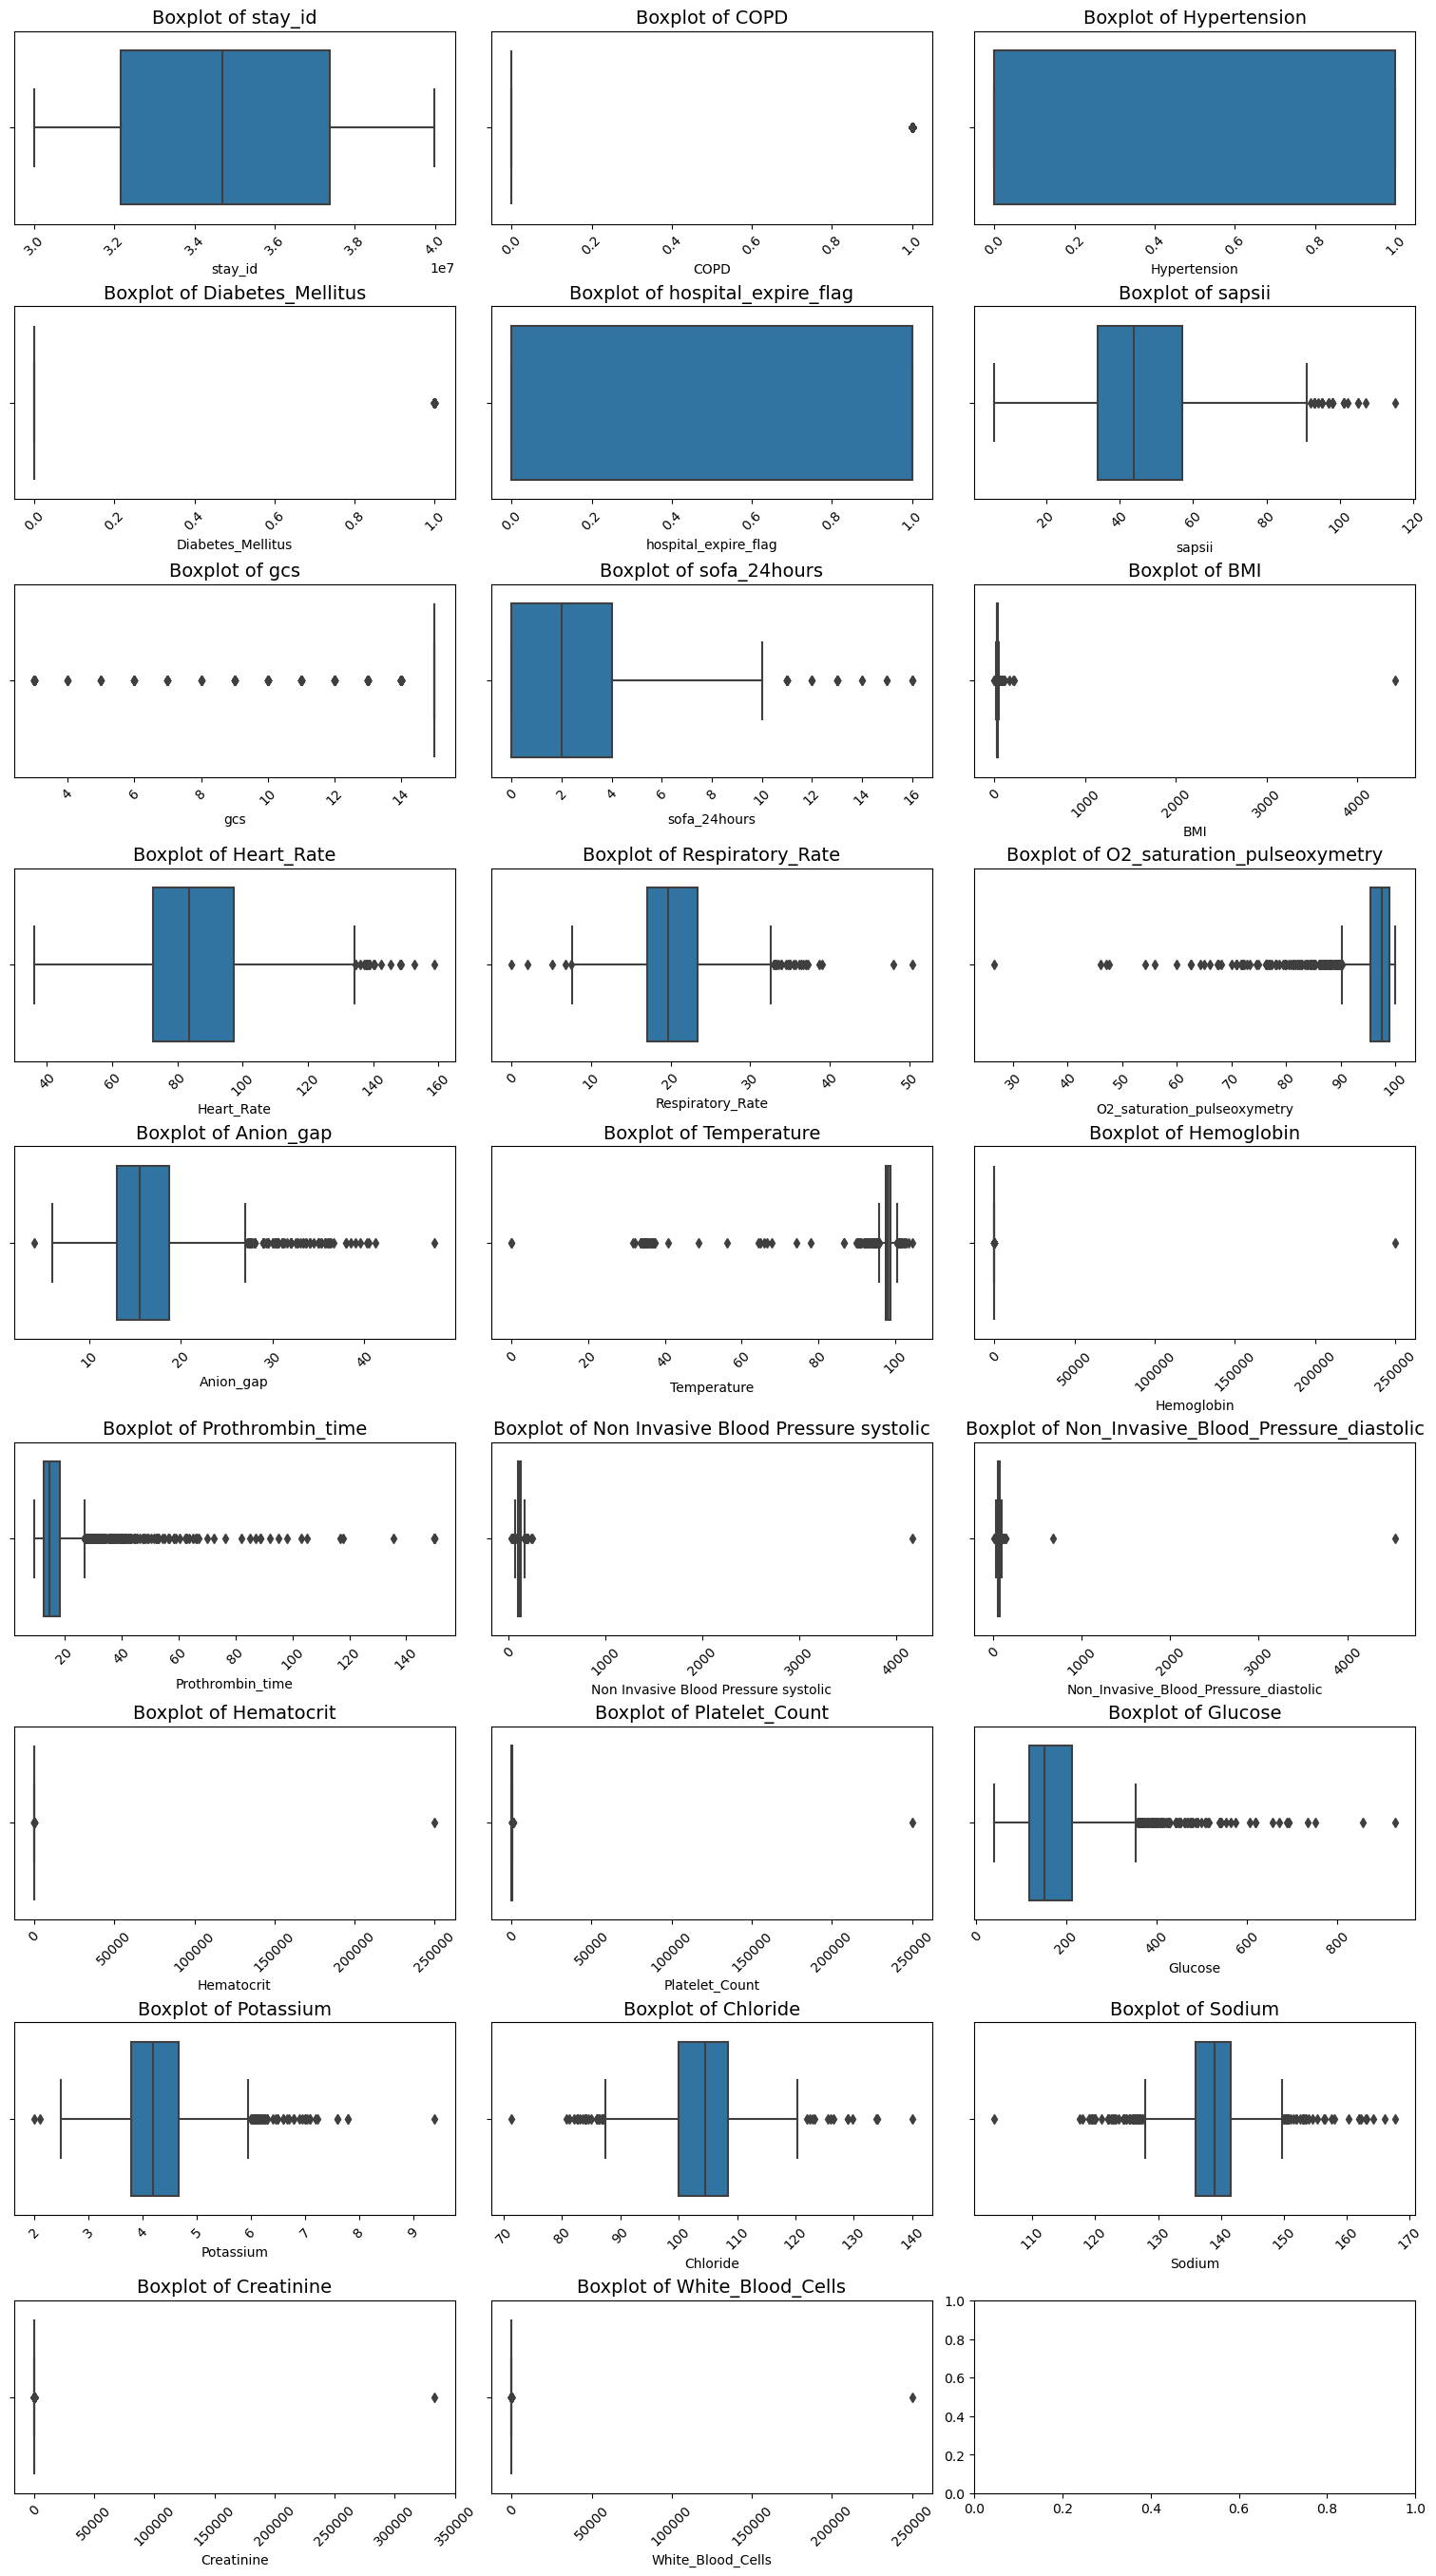

In [1063]:
# Filter out non-numeric columns
numeric_cols = merged_df_main.select_dtypes(include='number').columns

# Set up the plot grid
num_cols = len(numeric_cols)
num_rows = (num_cols // 3) + (1 if num_cols % 3 else 0)

# Adjust the figure size
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 3), constrained_layout=True)

# Flatten axes
axes = axes.flatten()

# Loop through the numeric columns and plot a boxplot for each
for i, column in enumerate(numeric_cols):
    sns.boxplot(x=merged_df_main[column], ax=axes[i])  
    axes[i].set_title(f'Boxplot of {column}', fontsize=14)  
    axes[i].tick_params(axis='x', rotation=45)  

plt.show()

In [1064]:
# Save to csv and find outliers 
merged_df_main.to_csv("Outlier_CA.csv")

In [1065]:
# Set index to stay id
merged_df_main.set_index('stay_id', inplace=True)
merged_df_main

,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,...,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine,White_Blood_Cells
stay_id,,,,,,,,,,,,,,,,,,,,,
34100191.0,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,...,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000,7.466667,14.766667
38292466.0,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,...,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667,2.166667,23.250000
38857852.0,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,...,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000,3.400000,8.600000
39625056.0,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,...,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000,1.800000,15.366667
37176427.0,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,...,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000,1.700000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37394079.0,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,...,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000,144.500000,2.250000,7.000000
31637227.0,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,...,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000,149.000000,1.450000,10.000000
37748758.0,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,...,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000,142.666667,0.600000,16.100000


In [1066]:
# Remove rows with outliers
outliers = [36538885,38860085,35398513,38146463,35672230,33351578]

for i in outliers:
    merged_df_main = merged_df_main[merged_df_main.index != i]

In [1067]:
# Create column with NaN counts for each row
merged_df_main['NaN_count'] = merged_df_main.isna().sum(axis=1)

In [1068]:
# Sort by NaN values
merged_df_main.sort_values(by='NaN_count', ascending=False)

,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,...,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine,White_Blood_Cells,NaN_count
stay_id,,,,,,,,,,,,,,,,,,,,,
38813153.0,0.0,1.0,0.0,1,F,79.73649799311141654027,46,NaN,1.0,29.115645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
33914855.0,0.0,0.0,0.0,1,M,90.8420654433681413,41,NaN,2.0,NaN,...,17.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
37743005.0,0.0,1.0,0.0,1,M,85.1528917052864189,44,NaN,1.0,NaN,...,40.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
38852627.0,1.0,1.0,0.0,1,M,79.92762697973763513871,32,NaN,1.0,NaN,...,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
36499196.0,0.0,0.0,0.0,1,F,83.39625554198768670270,37,NaN,1.0,21.098558,...,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32985167.0,0.0,1.0,0.0,1,F,91.50376987495048944718,49,13.0,3.0,27.779768,...,60.153846,32.266667,142.0,174.0,4.133333,100.666667,139.00,1.133333,6.9,0
38878651.0,0.0,0.0,0.0,0,F,70.2617397049992425,97,15.0,5.0,33.078323,...,68.866667,30.850000,145.5,137.5,3.366667,105.666667,145.00,3.700000,9.5,0
31042481.0,0.0,1.0,0.0,1,F,60.96302018022753863648,44,15.0,5.0,25.751989,...,71.785714,28.600000,49.0,85.0,4.825000,119.750000,143.25,0.625000,1.0,0


In [1069]:
# Filter for rows with greater than 93% non Null counts
merged_df_main = merged_df_main[merged_df_main['NaN_count'] < 3]

### Save
---

In [1070]:
# Drop unecessary column
merged_df_main = merged_df_main.drop(columns=['NaN_count'])
merged_df_main

,COPD,Hypertension,Diabetes_Mellitus,hospital_expire_flag,gender,age,sapsii,gcs,sofa_24hours,BMI,...,Non Invasive Blood Pressure systolic,Non_Invasive_Blood_Pressure_diastolic,Hematocrit,Platelet_Count,Glucose,Potassium,Chloride,Sodium,Creatinine,White_Blood_Cells
stay_id,,,,,,,,,,,,,,,,,,,,,
34100191.0,0.0,0.0,0.0,0,M,47.14951654580311744603,61,15.0,2.0,38.823337,...,99.000000,68.000000,37.333333,19.000000,289.666667,4.133333,96.666667,132.000000,7.466667,14.766667
38292466.0,0.0,0.0,0.0,0,M,85.2591994561900816,43,15.0,0.0,28.031430,...,91.300000,33.900000,25.450000,147.500000,107.000000,4.733333,92.000000,126.666667,2.166667,23.250000
38857852.0,0.0,0.0,0.0,0,F,56.8812384817615596,33,15.0,3.0,63.636804,...,108.538462,62.230769,37.700000,158.000000,330.000000,4.800000,87.000000,131.000000,3.400000,8.600000
39625056.0,0.0,0.0,0.0,1,M,78.86053105429642082053,65,15.0,3.0,27.725383,...,99.000000,63.000000,32.975000,153.666667,236.250000,4.775000,105.750000,137.500000,1.800000,15.366667
37176427.0,0.0,1.0,0.0,0,M,62.70961703321207430811,28,15.0,2.0,26.418642,...,103.153846,75.692308,37.500000,191.000000,93.000000,5.100000,84.000000,119.000000,1.700000,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37394079.0,0.0,0.0,0.0,1,M,85.7386194176281297,47,14.0,5.0,23.197831,...,151.647059,83.705882,27.700000,127.000000,234.500000,4.750000,111.500000,144.500000,2.250000,7.000000
31637227.0,0.0,0.0,0.0,0,F,46.21383843527791923650,41,15.0,2.0,47.592249,...,105.230769,58.384615,37.100000,58.000000,202.500000,5.800000,113.000000,149.000000,1.450000,10.000000
37748758.0,0.0,0.0,1.0,0,F,69.70848574369869839723,49,15.0,3.0,29.929926,...,111.750000,47.750000,37.900000,153.500000,128.666667,3.733333,116.000000,142.666667,0.600000,16.100000


In [1071]:
# Save csv
merged_df_main.to_csv("CA_DF.csv")